# CNN Hands on:

This notebook represents a hands on tutorial for Convolutional Neural Networks (CNN). It will show you the basic concepts and how to implement them in python using tensorflow. In principle using and playing with CNNs does not require any large overhead or fancy computer system. You can directly start with your laptop if you like.  

Please note that this notebook shall only give you a first impression and does not replace a full lecture about machine learning. I will try to explain all relevant aspects as good as I can.

## Description of the classification problem:

Often CNNs are used to classify images into different categories. This can range from a simple binary classification with just two classes to more complex cases with dozens of output classes. In this particular example we will look into how we can classify data into signal and background based on the time, position and recorded charge information of a given signal. 

In particular I am interested in classifying signals of the XENONnT water Cherenkov neutron-veto. The XENONnT experiment is a dark matter experiment designed to search for WIMP dark matter using a liquid xenon time projection chamber.  A CAD rendering of the XENONnT experiment shown in the subsequent image. 

![XENONnT CAD](images/xenonnt_cad.png)

The new neutron-veto is the white octagonal shaped structure surrounding the inner TPC cryostat. It consists out of 120 PMTs which are arranged in 20 columns with 6 PMT rows. White ePTFE reflector panels are mounted to the neutron-veto support structure to maximize the light collection efficiency of the neutron-veto. As the name suggests the neutron-veto shall veto neutrons which can undergo so called single scatter nuclear recoils which are indistinguishable from dark matter signals. Neutrons escaping the TPC cryostat are detected by measuring Cherenkov light after a neutron is captured on hydrogen. The capture releases the neutron binding energy of the formed deuterium which results into a 2.2 MeV gamma-ray. Due to subsequent Compton scattering the gamma-ray transfers its energy to electrons which produce the Cherenkov light. 

The majority of the neutron-veto background originates from its outer walls. Primarily from the PMTs itself. The quartz glass of the PMTs contains radioactive isotopes like U238, Th232 or K40 which produce different background signals. One of those signals is a 2.6 MeV gamma line from the Th232 decay chain which has a similar energy than our neutron-capture signals.  

Hence, the origin of neutron and background signals are located at very different positions in the detector leading to slightly different hit-patterns. Since a full detector simulation would be too much for the tutorial we decided to write small toy MC event generator which generates event in a simple 2d plain.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

from simulator.toy_mc import NeutronVetoToyLightPropagator

In [2]:
pmts_in_z_slice = np.load('./data/toy_mc_pmt_positions.npy')

# Simple ToyMC example:

The main idea is based on the fact that depending on the position of light emission the TPY cryostat shadows different PMTs and hence light propagation takes differently long. To mimic this behavior the toy MC computes the following steps: 

1. depending on the source positions which PMTs can be directly illuminated. 
2. compute how long the light will need to propagate from the emission point to the corresponding PMTs. 
3. estimate the shorted reflection path to the PMTs which are illuminated by scattered light.
    1. Use as starting points the directly illuminated PMTs. 
    2. Compute which of the not yet illuminated PMTs can be reached from this point
    3. Compute light propagation for all possibilities and take the shortest flight path. 
    
The photon reflection is mostly diffuse and not specular. In the subsequent plots the minimal light propagation time for a neutron-like and background-like event are shown. The dots indicate the positions of the different PMTs the times the minimal propagation times. Red points can only be indirectly illuminated. The orange diamond represents the position of light emission. The black circle the TPC cryostat.

In [3]:
emission_point = np.array([[0, -90, 0]])
neutron_model = NeutronVetoToyLightPropagator(
    81.5, 
    pmts_in_z_slice,
    emission_point,
)

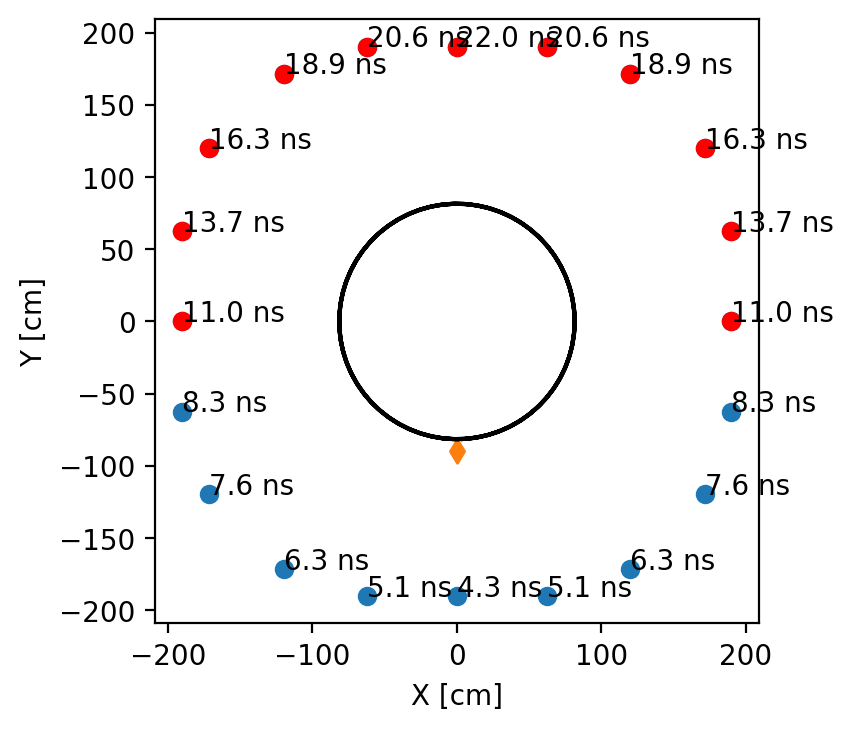

In [4]:
fig = neutron_model.plot_light_propagation(0)
fig.set_dpi(200)
fig

Background source position:

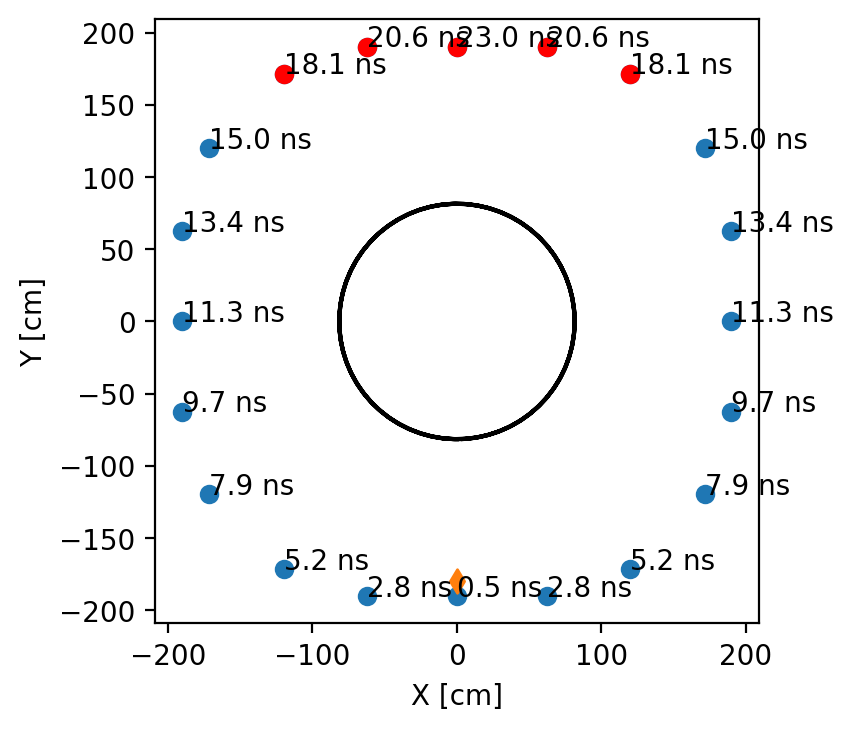

In [5]:
emission_point = np.array([[0, -180, 0]])
bkg_model = NeutronVetoToyLightPropagator(81.5, 
                                          pmts_in_z_slice,
                                          emission_point,
                                         )
fig = bkg_model.plot_light_propagation()
fig.set_dpi(200)
fig

In the next step the MC distributes a number of photons according to this light propagation distribution. In general we know from data that the light distributes as an exponentially declining distribution. Hence, to create the individual events we are performing the following steps:

1. Draw number of photons from a Poisson distribution. We assume that detector thresholds sensor efficiency etc. have been already applied. 
2. Draw photon arrival time from an exponential distribution. 
3. Check which PMTs can be reached for the given time stamp and chose one from a uniform distribution.
4. Smear timing a bit according to a normal distribution.

### Light cone distribution:

To create events/signals according to the steps above we can call the function `generate_events` which takes 5 arguments:

1. `n_events` simply represents how many events we would like to simulate. This number will therefore determine how large our training set is going to be.
2. `n_photons_per_event` represents the number of recorded photons per event. Please note that we wanted to stay simple for this tutorial. Hence, we do not apply any quantum efficiency nor photo-sensor threshold. The number of recorded photons are simply drawn from a Poisson distribution.
3. `spread_charge_distribtuion` mimics the spread of the photon charge distribution of our sensors. 
4. `lowest_charge_allowed` should mimic the detector threshold. None of the recorded photons can have a charge lower than this value.
5. `time_spread` allows to add some extra smearing to the photon arrival time after drawing a photosensor channel.

The function will return you 4 arrays. The first array is an offset array of the length `n_events`. It contains the information how many photons can be found in each individual event. This is necessary as the standard numpy library does not allow to store arrays with arbitrary lengths. This would require packages like [awkward arrays](https://awkward-array.org/quickstart.html) which are going beyond the scope of this tutorial.
The other three arrays are also flat arrays which have the length of the total sum of the offset array. Those arrays contain the time, channel and charge information for each individual photon. 

In [6]:
n_events = 10**3
n_photons_per_event = 26
spread_charge_distribtuion = 0.3
lowest_charge_allowed = 0.15


offsets_n, times_n, channel_n, areas_n = neutron_model.generate_events(n_events, 
                                                                       n_photons_per_event, 
                                                                       spread_charge_distribtuion, 
                                                                       lowest_charge_allowed)
n_ph_per_source_n = np.sum(offsets_n, axis=1)


offsets_bkg, times_bkg, channel_bkg, areas_bkg = bkg_model.generate_events(n_events, 
                                                                           n_photons_per_event, 
                                                                           spread_charge_distribtuion, 
                                                                           lowest_charge_allowed)
n_ph_per_source_bkg = np.sum(offsets_bkg, axis=1)

Let us know inspect a little bit the data with a simple histogram:

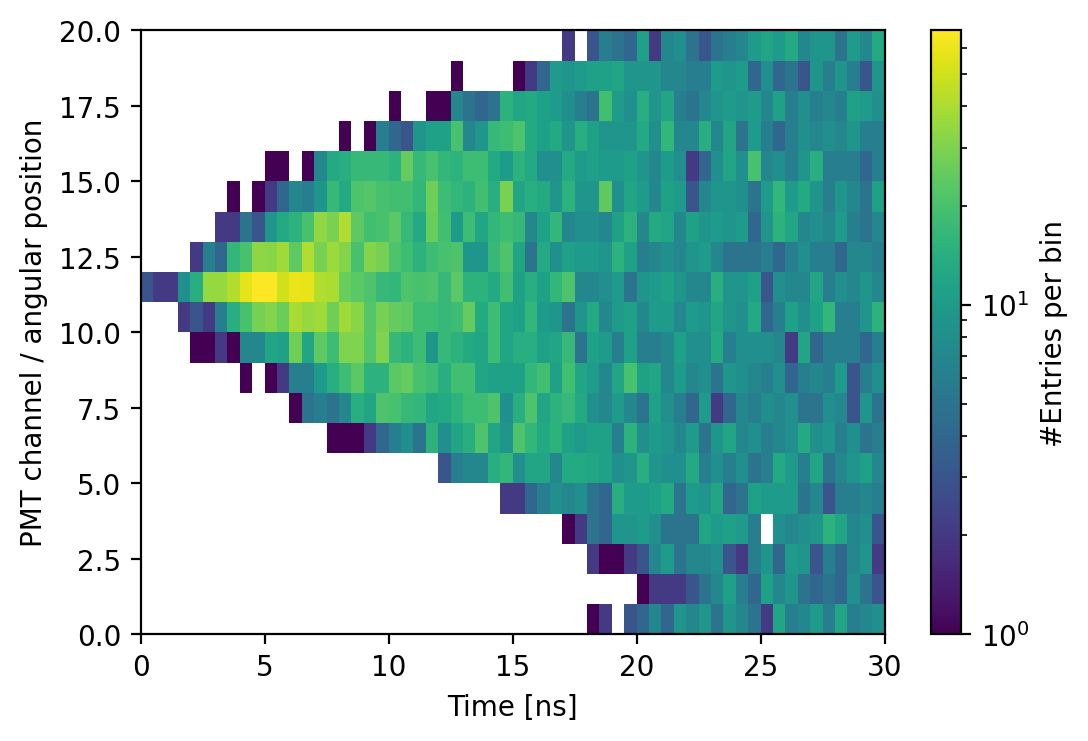

In [7]:
plt.figure(dpi=200)
plt.hist2d(times_n, 
           channel_n,
           bins=(60, 20), range=((0, 30), (0, 20)),
           norm=matplotlib.colors.LogNorm()
          )
plt.colorbar(label='#Entries per bin')
plt.xlabel('Time [ns]')
plt.ylabel('PMT channel / angular position')
plt.show()

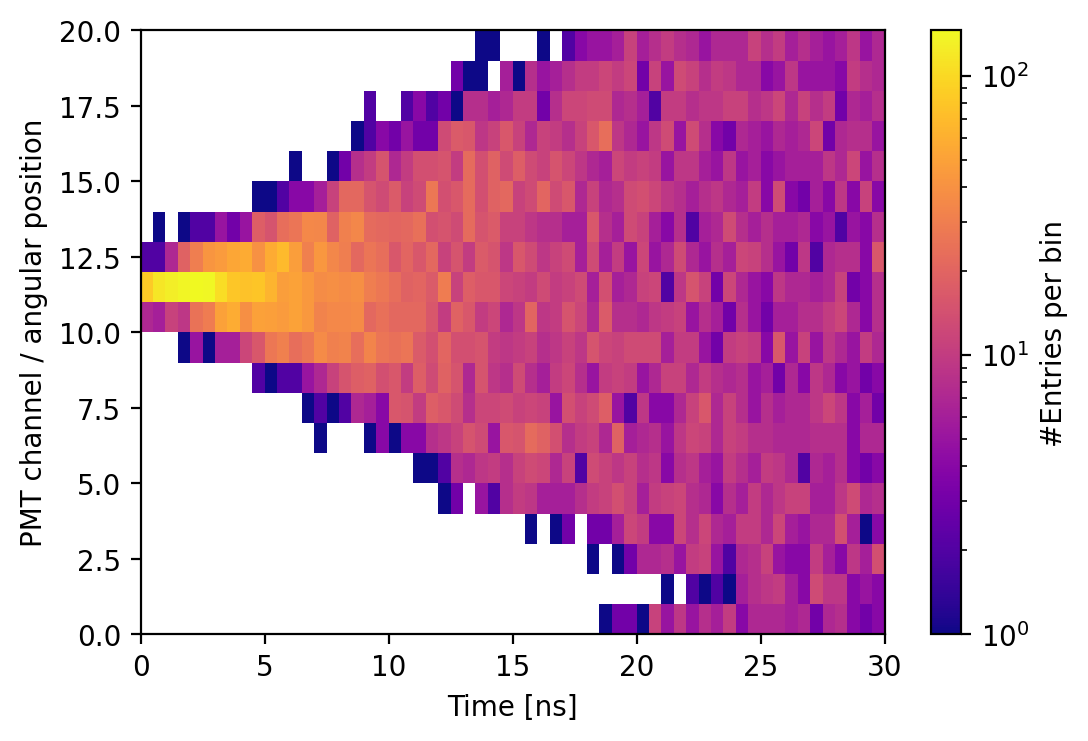

In [8]:
plt.figure(dpi=200)
plt.hist2d(times_bkg, 
           channel_bkg,
           bins=(60, 20), range=((0, 30), (0, 20)),
           norm=matplotlib.colors.LogNorm(),
           cmap='plasma'
          )
plt.colorbar(label='#Entries per bin')
plt.xlabel('Time [ns]')
plt.ylabel('PMT channel / angular position')
plt.show()

You can see that both background and neutrons follow a cone shaped like structure which differs a bit in shape. This difference in shape is what we would like to exploit for our classification.

If you like you can play a bit and try to plot the spatial time distributions for different source positions.

### Create images:

Before we can start implementing our first CNN we have to convert our toy MC data into images. Therefore let us create a first a small set of additional data....

In [9]:
n_events = 1*10**3
n_ph = 25
photon_charge_resolution = 0.3
photon_charge_threshold = 0.15  

offsets_n, times_n, channel_n, charge_n = neutron_model.generate_events(n_events, 
                                                                        n_ph,
                                                                        photon_charge_resolution,
                                                                        photon_charge_threshold,
                                                                       )

offsets_bkg, times_bkg, channel_bkg, charge_bkg = bkg_model.generate_events(n_events, 
                                                                            n_ph,
                                                                            photon_charge_resolution,
                                                                            photon_charge_threshold,
                                                                           )


... which we will now convert into some images using the following function:

In [10]:
images_n = neutron_model.make_sample(offsets_n, 
                                     times_n, 
                                     channel_n, 
                                     charge_n, 
                                     time_bins=np.arange(0, 32.1, 2)
                                    )
images_bkg = bkg_model.make_sample(offsets_bkg, 
                                   times_bkg, 
                                   channel_bkg, 
                                   charge_bkg, 
                                   time_bins=np.arange(0, 32.1, 2)
                                  )

We can also display some of these images:

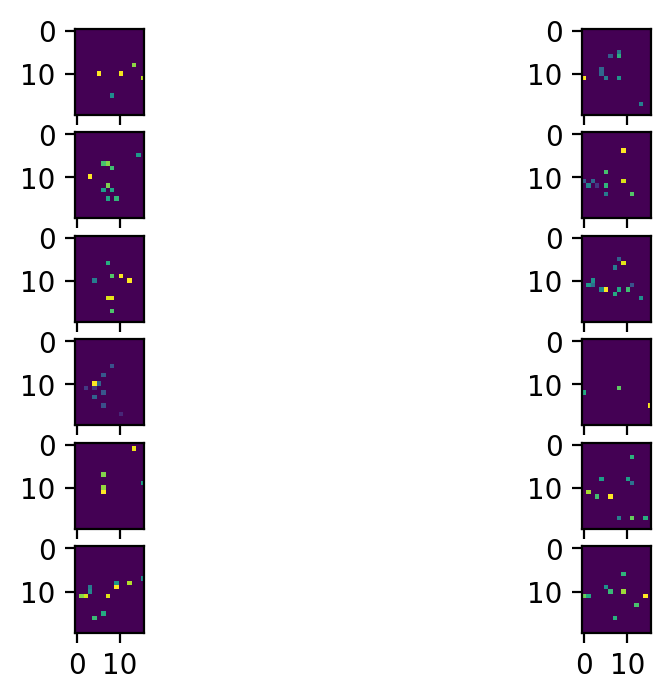

In [11]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=200, sharex=True)
for ind, (i_n, i_g) in enumerate(zip(images_n[:6], images_bkg[:6])):
    axes[ind, 0].imshow(i_n)
    axes[ind, 1].imshow(i_g)

In [12]:
images_n.shape

(1000, 20, 16)

As you can see created now 1k images with a shape of 20 x 16 for both our neutrons and our background. Can you tell which image belongs to which source?

## Image preprocessing:

In most Convolutional Neural Network applications images from our daily life are used. E.g. for the recognition of street signs. Usually these images can have different shapes and color-scaling which makes image preprocessing for those applications a very important point. In our example we know already that all images are going to have the very same shape. This should be true for most of detector based applications.  

However also for our data we have to perform two task for our image preprocessing.

### Normalization:

Normalization is simple. We just have to make sure that the "gray-scale" (measured charge per pixel) of our images are well defined. E.g. that all charge values are normalized to the range between (0, 1). 

In [13]:
max_charge_n = np.max(images_n)
images_n /= max_charge_n

max_charge_bkg = np.max(images_bkg)
images_bkg /= max_charge_bkg

### Data labeling and splitting:

The second task we have to perform is to label our data and split it into a training and a validation data set. Let us start with the labeling. Using labeled data is one of the approaches how we can teach our computer how to perform a certain task. The algorithm will try to predict to which of our categories an images belongs and compares it with its corresponding label. Depending whether the prediction was correct or not the algorithm will adjust itself. 

To label our data we have to create an array filled with zeros of the size `n x m` where `n` represents the number of images we have and `m` the number of categories. In case an image `n_i` belongs to the category `m_i` we set the corresponding value to 1. E.g. that our labels look like

```
0, 1, 0, 0,
1, 0, 1, 1,
```

assuming that only the second image belongs to the first category. 

In [14]:
assert len(images_n) == len(images_bkg)
n_events = len(images_n)

# Make common image buffer:
images = np.concatenate([images_n, images_bkg])

# Create labels for images:
image_labels = np.zeros((2*n_events, 2), dtype=np.int8)
image_labels[:n_events, 0] = 1
image_labels[n_events:, 1] = 1

After labeling our data we should shuffle it. Usually we will train our CNN in batches of a certain size and we should make sure that each batch contains images of the different categories. Hence let us shuffle our images and labels:

In [15]:
# Shuffle data and create training and validation set:
inds = np.arange(0, 2*n_events, 1)
np.random.shuffle(inds)
images = images[inds]
image_labels = image_labels[inds]

Last but not least we should split our data in a training and a validation data set. As the names suggest the training data set is only used for the training of our CNN while the validation data is used for validating our algorithm. We will also see in  a bit why the validation plays an important role.

Usually, people recommend to use a 80:20 splitting so let use this one for the moment. 

In [16]:
fraction_training = 0.8

n_training = int(n_events*fraction_training)
images_training = images[:n_training]
labels_training = image_labels[:n_training]

n_valid = n_events - n_training
images_validation = images[-n_valid:]
labels_validation = image_labels[-n_valid:]

Let us check once more a few images. Can we train your brain to distinguish neutrons from background when we provide you with images and labels? 

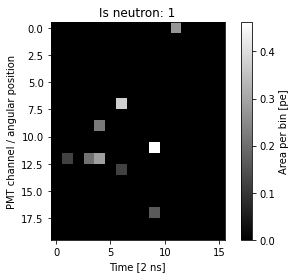

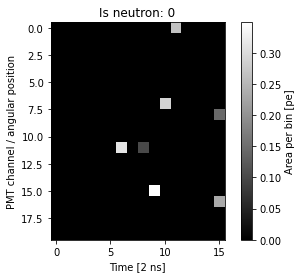

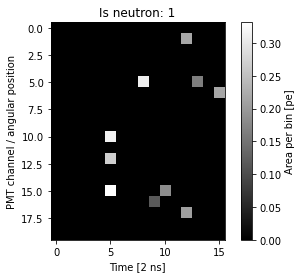

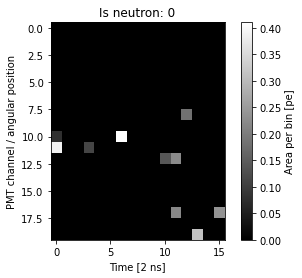

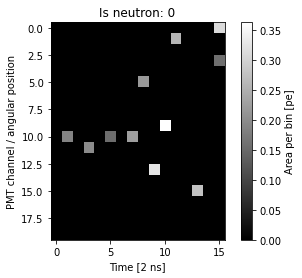

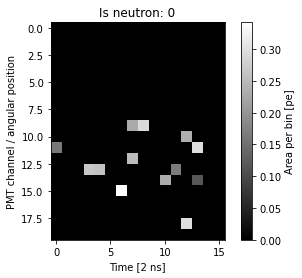

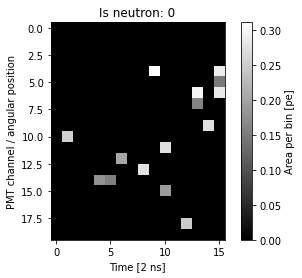

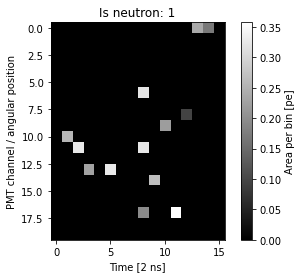

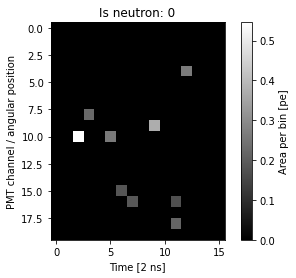

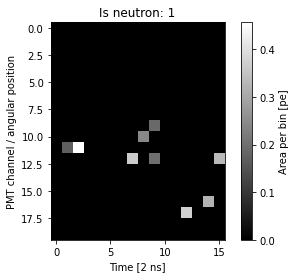

In [17]:
for i in range(10):
    plt.figure()
    plt.title(f'Is neutron: {labels_training[i, 0]}')
    image = plt.imshow(images_training[i], cmap='gray')
    plt.xlabel('Time [2 ns]')
    plt.ylabel('PMT channel / angular position')
    plt.colorbar(image, label='Area per bin [pe]')

# Your first NN:

Okay after we prepared now our data we can start with your first Neural Network. In this tutorial we are going to use tensorflow to set up our Neural Network. Typically, a neural net is composed of a sequential stack of different layers. Each layer can perform a different task depending on the application. Let us start with something simple which is made out of set of different dense layers.

In [18]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

2022-04-11 17:55:08.391862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/XENONnT/anaconda/envs/XENONnT_development/lib64:/opt/XENONnT/anaconda/envs/XENONnT_development/lib:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib:/opt/rh/devtoolset-9/root/usr/lib64/dyninst:/opt/rh/devtoolset-9/root/usr/lib/dyninst:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib
2022-04-11 17:55:08.391894: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


You can set-up a sequence of layers by initializing...

In [19]:
my_first_nn = Sequential()

2022-04-11 17:55:10.200738: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/XENONnT/anaconda/envs/XENONnT_development/lib64:/opt/XENONnT/anaconda/envs/XENONnT_development/lib:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib:/opt/rh/devtoolset-9/root/usr/lib64/dyninst:/opt/rh/devtoolset-9/root/usr/lib/dyninst:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib
2022-04-11 17:55:10.200768: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-11 17:55:10.200789: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (midway2-0464.rcc.local): /proc/driver/nvidia/version does not exist
2022-04-11 17:55:10.201040: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFl

and simply adding layers to the sequence:

In [20]:
my_first_nn.add(Flatten(input_shape=(20, 16, 1)))
my_first_nn.add(Dense(100, activation='relu'))
my_first_nn.add(Dense(50, activation='relu'))
my_first_nn.add(Dense(2, activation='softmax'))

In this particular example we are just adding two different types of layer a `Flatten` layer and a `Dense` layer. The `Flatten` layer as the name suggest converts an array/image of an arbitrary size into a flat single dimensional array. This has to be done depending on the output form of the desired sequence. 

The `Dense` layer is the typical layer of neurons which you might have in mind when thinking of neural networks. A dense layer is fully connected with all outputs of the previous and all inputs of the next layer. For each of the connections our neural network is parameterized by a so called weight parameter `w_j,i`. In addition each neuron has an additional bias term `w_0,i`. The subsequent image illustrates a system of dense layers which are given by an input layer **X** a hidden layer **Z** and an output layer **Y**:

<img src="images/illustration_dense_layer.png" alt="llustration dense layers" style="width: 600px;"/>

The values of the different neurons `z_i` are then simple given by

$$z_i = g\bigg( w_{0,i}^{(1)} + \sum_{j=1}^2 x_j \cdot w_{j,i}^{(1)} \bigg)$$

where $g$ represents the so called activation function. Activation functions are usually non-linear function as otherwise the equation above would only allow for linear models. In our Code example we use for the first two layers the so called "Rectified Linear Unite" or short `relu`. Which is defined as zero in case its argument is smaller zero or just the argument itself in case it is larger zero.

The final output layer is computed in the same way. You only have to replace $x_j$ with $z_j$ and change the summation. But here we are using the sigmoid function as activation function. The advantage of the sigmoid function is that its output is defined in the range between 0 and 1. So we can treat its output in a somewhat probabilist sense. (Although this probability does not tell you anything about the confidence in your prediction. E.g. you can train a NN to distinguish green apples from red apples. If you ask the prediction of your model for a green frog it will most likely tell you with a high probability that it is going to be a green apple.)

When ever you make a new model it make sense to quickly print its statistics via:

In [21]:
my_first_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 100)               32100     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 37,252
Trainable params: 37,252
Non-trainable params: 0
_________________________________________________________________


Our current model has about 37k parameters which we have to train. The number of parameters depends on the number of weights and bias terms mentioned above in our current example we are doing the following:

1. We flatten our image from a size 20 x 16 x 1 into single dimensional array of the size 320. 
2. We connect all the 320 outputs of the flatten layer with the 100 neurons of our dense layer. Hence, we are getting 32000 parameters due to weights and an other 100 due to one bias term per neuron. 
3. In the next step we are connecting our 100 outputs with the 50 neurons of the next layer. Which gives another 5000 weights plus 50 bias terms.
4. The last layer should represent our output. Since we are trying to categorize our data we only need here one neuron per category. In our case just two. Therefore, we will get another 102 parameters.

When compiling our data we have to specify the loss function and the optimizer which should be used. In general you can think of the loss function as something similar to a negative Log-Likelihood or Least Squares function which you are used to when fitting a model onto some data points. In both cases, fitting and machine learning, the goal is to minimize the loss function to achieve the best possible result. In our example we will use `keras.losses.binary_crossentropy` which represents the binary cross entropy of our categories. Depending on your application you have to replace this loss function with a different one.

In addition to the loss function one also has to specify the `optimizer` which should be used to find the minimum in our loss function. In general one can find the minimum of a loss function by moving into the direction of the negative gradient of the loss function. There are many different methods to compute the gradient e.g. `stochastic gradient descent`.

In many cases the so called `Adam` (Adaptive Movement Estimation) optimizer is recommended.  

In [22]:
my_first_nn.compile(loss=keras.losses.binary_crossentropy, 
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy']
                   )

After compiling our model we can check how good it performs on our data. Lets try to see with which probability the first images is predicted to be a neutron or not. We can get a prediction by our model by simply using the `.predict` method.

In [23]:
prediction = my_first_nn.predict(images[:100])
print('Predicted probability that the first image is a neutron '
      f' {prediction[0, 0]*100:.1f} % instead of background.')

Predicted probability that the first image is a neutron  51.4 % instead of background.


A 50:50 chance that the image is a neutron image or not is not really helpful yet. Lets try with a larger sample. Attached with this tutorial you can find a file called `tools.py` which contains a with helper function for the analysis of our model. 
For now we just need `get_correaltion` and `plot_confusion_matrix` to compute the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) of our data.  

In [24]:
from tools import get_correaltion, plot_confusion_matrix

So now let us check the predictions for the first 100 images.

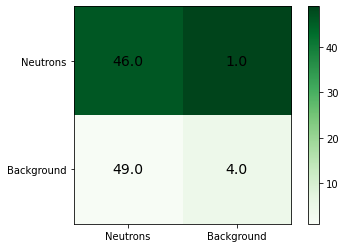

In [25]:
cm = get_correaltion(prediction, image_labels[:100])
fig = plot_confusion_matrix(cm, ['Neutrons', 'Background'])

You can see that our model does not really perform very well and many images are categorized as false positives (background being classified as neutrons) and false negatives (neutrons being classified as background). The reason for this poor performance comes from the fact that we have not trained our model yet. 

We can try our neural net using the fit method of our model. As arguments we have to pass our training and validation images as well as the so-called **batch size** and the number of **epochs** we would like to train our data. 

The **batch size** represents the number of inputs/images to be used to compute the negative gradient of our log-function. A larger batch size will result in a more precise estimate of the gradient. However, a too large batch size may lead to a slower learning rate as we only move only along the negative gradient once it is computed. Batch size typically are given in units of $2^n$. 

The number of **epochs** represents how often we will repeat the training of our neural net using our input data. Each time the input is shuffled again before training another epoch.

Let us train our simple model with 128 images per batch for 100 epochs:

In [26]:
batch_size = 128
epochs = 100

In [27]:
training_statistics = my_first_nn.fit(images_training, 
                                      labels_training, 
                                      batch_size=batch_size, 
                                      epochs=epochs,  
                                      validation_data=(images_validation, labels_validation),
                                     )

Epoch 1/100
7/7 [==============================] - 1s 25ms/step - loss: 0.6929 - accuracy: 0.5263 - val_loss: 0.6901 - val_accuracy: 0.5600
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.6488 - val_loss: 0.6869 - val_accuracy: 0.6550
Epoch 3/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.7300 - val_loss: 0.6817 - val_accuracy: 0.6950
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6716 - accuracy: 0.7550 - val_loss: 0.6749 - val_accuracy: 0.7050
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6598 - accuracy: 0.7750 - val_loss: 0.6648 - val_accuracy: 0.7100
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.8012 - val_loss: 0.6506 - val_accuracy: 0.7250
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.8200 - val_loss: 0.6312 - val_accuracy: 0.7200
Epoch 8/100
7/7 [=========

7/7 [==============================] - 0s 4ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 1.1987 - val_accuracy: 0.6750
Epoch 60/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 1.2133 - val_accuracy: 0.6700
Epoch 61/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 1.2203 - val_accuracy: 0.6750
Epoch 62/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 1.2283 - val_accuracy: 0.6750
Epoch 63/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 1.2386 - val_accuracy: 0.6750
Epoch 64/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.2512 - val_accuracy: 0.6700
Epoch 65/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 1.2617 - val_accuracy: 0.6700
Epoch 66/100
7/7 [===============

Based on the printout we can see that the accuracy of our model is 100 %. When computing the confusion matrix it looks indeed like our model makes a perfect prediction. 

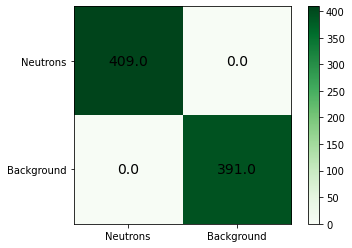

In [28]:
prediction = my_first_nn.predict(images_training)
cm = get_correaltion(prediction, labels_training)
fig = plot_confusion_matrix(cm, ['Neutrons', 'Background'])

Let repeat the exercise for our validation data:

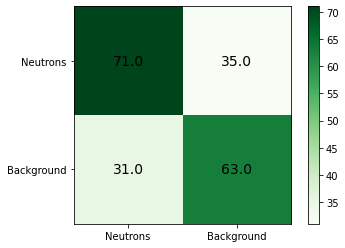

In [29]:
prediction = my_first_nn.predict(images_validation)
cm = get_correaltion(prediction, labels_validation)
fig = plot_confusion_matrix(cm, ['Neutrons', 'Background'])

In [30]:
(cm[1,0] + cm[0,1])/np.sum(cm)

0.33

In case of our validation data we get an accuracy of just 40 %? During training the results of our fitting history are stored in `training_statistics`. So let us have a look into the accuracy and loss for the training and validation data:

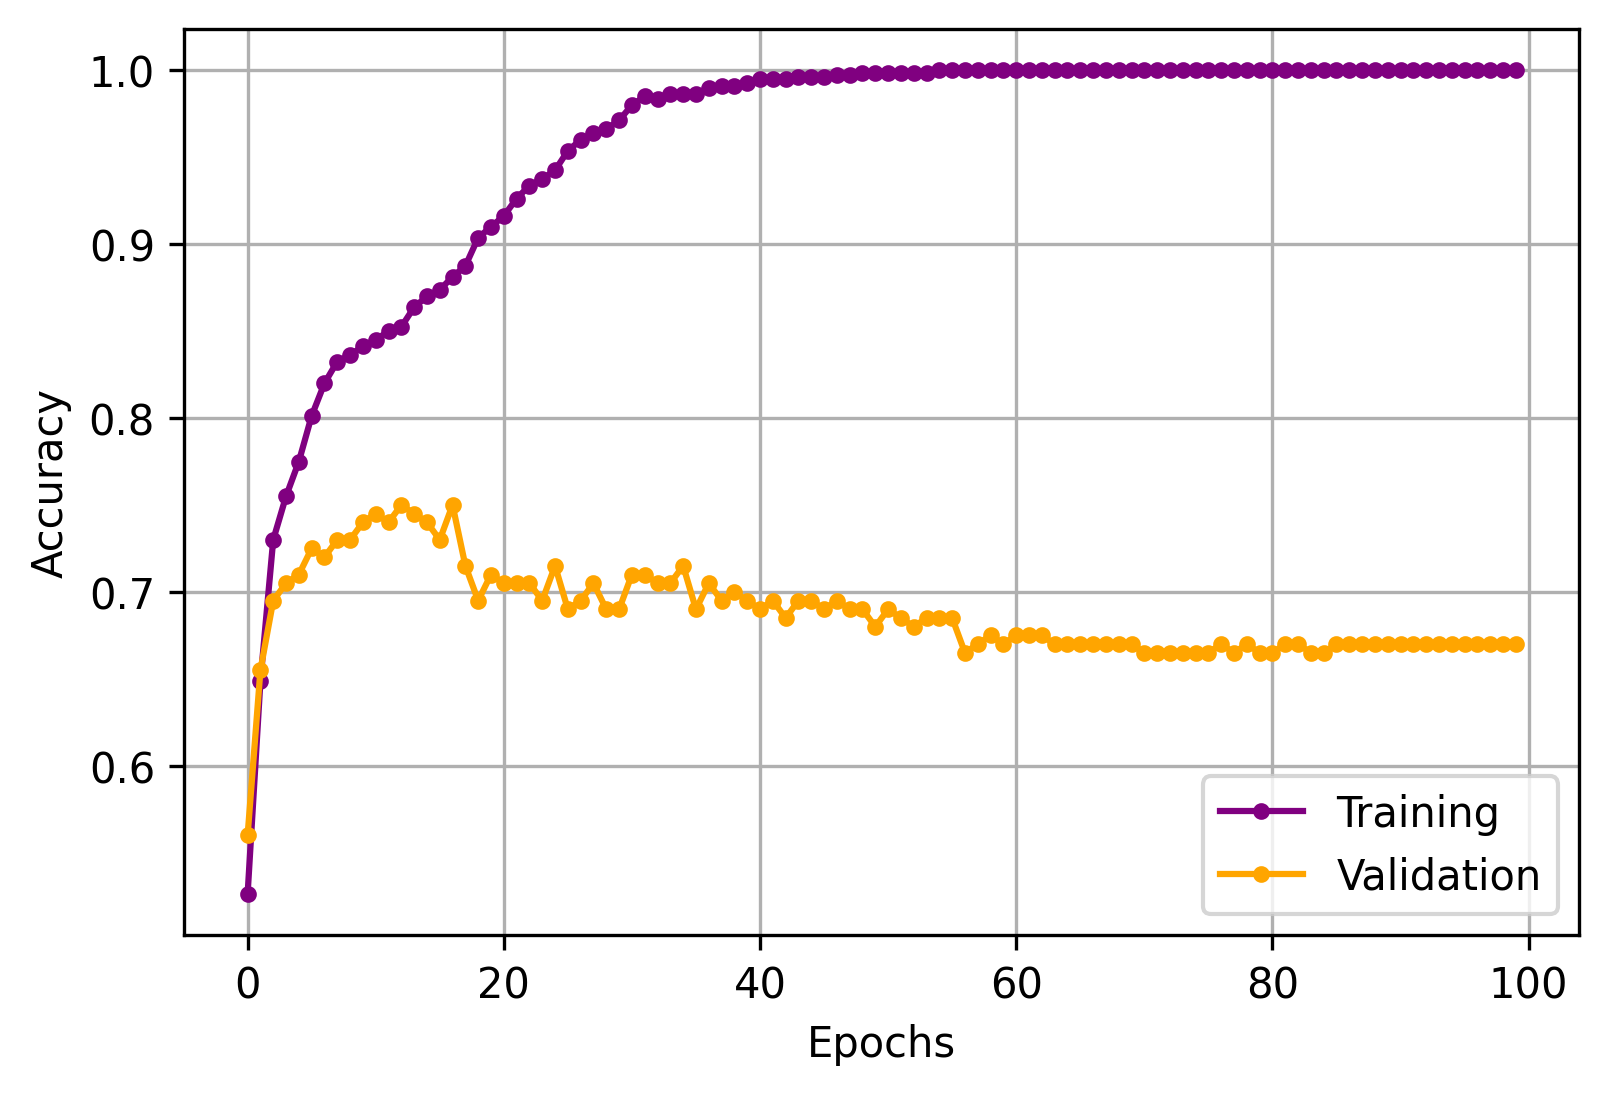

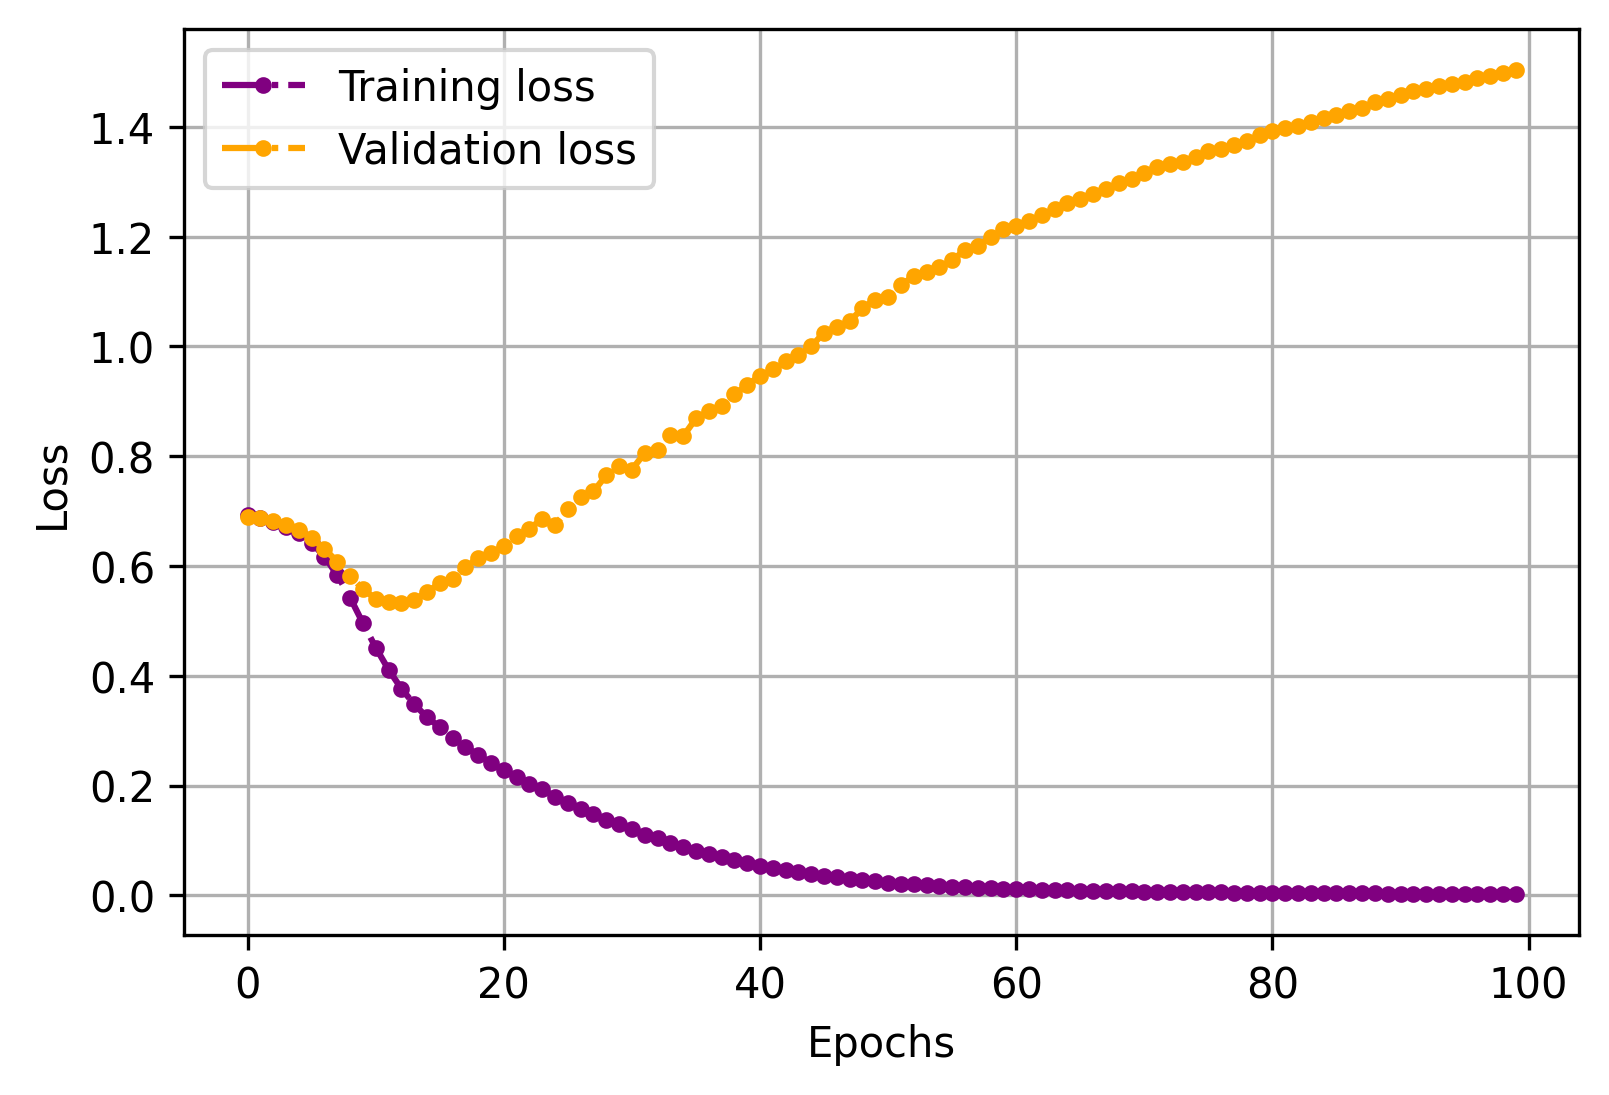

In [31]:
fig, axis = plt.subplots(dpi=300)
axis.plot(training_statistics.history['accuracy'], ls='-', marker='.', label='Training', color='purple')
axis.plot(training_statistics.history['val_accuracy'], ls='-', marker='.', label='Validation', color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()


fig, axis = plt.subplots(dpi=300)
axis.plot(training_statistics.history['loss'], ls='-.', marker='.', label='Training loss', color='purple')
axis.plot(training_statistics.history['val_loss'], ls='-.', marker='.', label='Validation loss', color='orange')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

So while the accuracy for the training data became 1 and the its loss function was reduced to 0, the loss function of the validation data starts to rise after about 15 epochs and its accuracy goes down. 

This behavior is called **overfitting** and is the reason why validation data is so important. Overfitting in machine learning typically happens for the same reason as for a regular fit you are more familiar with. If the number of your data points is small compared to the number of parameters in your model you are going to overfit your data. This means your model can precisely remember how your data looked like. Hence, it performs very well on this particular set of images, but performs worse on any other data. 

To avoid over fitting few different techniques can be applied. One thing which we can do is adding so called drop out layers to our network. Dropout layer randomly set a fraction of our layer weights to zero. In this way we can prevent over fitting.

In [32]:
from tensorflow.keras.layers import Dropout

So let us add two drop out layers and repeat the exercise from above:

In [33]:
my_first_nn = Sequential()
my_first_nn.add(Flatten(input_shape=(20, 16, 1)))
my_first_nn.add(Dense(100, activation='relu'))
my_first_nn.add(Dropout(0.1))
my_first_nn.add(Dense(50, activation='relu'))
my_first_nn.add(Dropout(0.2))
my_first_nn.add(Dense(2, activation='softmax'))

my_first_nn.compile(loss=keras.losses.binary_crossentropy, 
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy']
                   )


my_first_nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               32100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 102       
                                                                 
Total params: 37,252
Trainable params: 37,252
Non-trai

In [34]:
training_statistics = my_first_nn.fit(images_training, 
                                      labels_training, 
                                      batch_size=batch_size, 
                                      epochs=epochs,  
                                      validation_data=(images_validation, labels_validation),
                                     )

Epoch 1/100
7/7 [==============================] - 1s 22ms/step - loss: 0.6923 - accuracy: 0.5263 - val_loss: 0.6905 - val_accuracy: 0.5900
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6868 - accuracy: 0.6250 - val_loss: 0.6871 - val_accuracy: 0.6350
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6812 - accuracy: 0.6825 - val_loss: 0.6828 - val_accuracy: 0.6650
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6743 - accuracy: 0.7250 - val_loss: 0.6767 - val_accuracy: 0.6750
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6641 - accuracy: 0.7425 - val_loss: 0.6677 - val_accuracy: 0.7000
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.7825 - val_loss: 0.6545 - val_accuracy: 0.7000
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.7975 - val_loss: 0.6358 - val_accuracy: 0.7050
Epoch 8/100
7/7 [=========

7/7 [==============================] - 0s 4ms/step - loss: 0.0190 - accuracy: 0.9987 - val_loss: 1.1054 - val_accuracy: 0.6800
Epoch 60/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 1.1231 - val_accuracy: 0.6800
Epoch 61/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 1.1258 - val_accuracy: 0.6750
Epoch 62/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 1.1314 - val_accuracy: 0.6850
Epoch 63/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 1.1454 - val_accuracy: 0.6750
Epoch 64/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 1.1651 - val_accuracy: 0.6800
Epoch 65/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 1.1722 - val_accuracy: 0.6800
Epoch 66/100
7/7 [===============

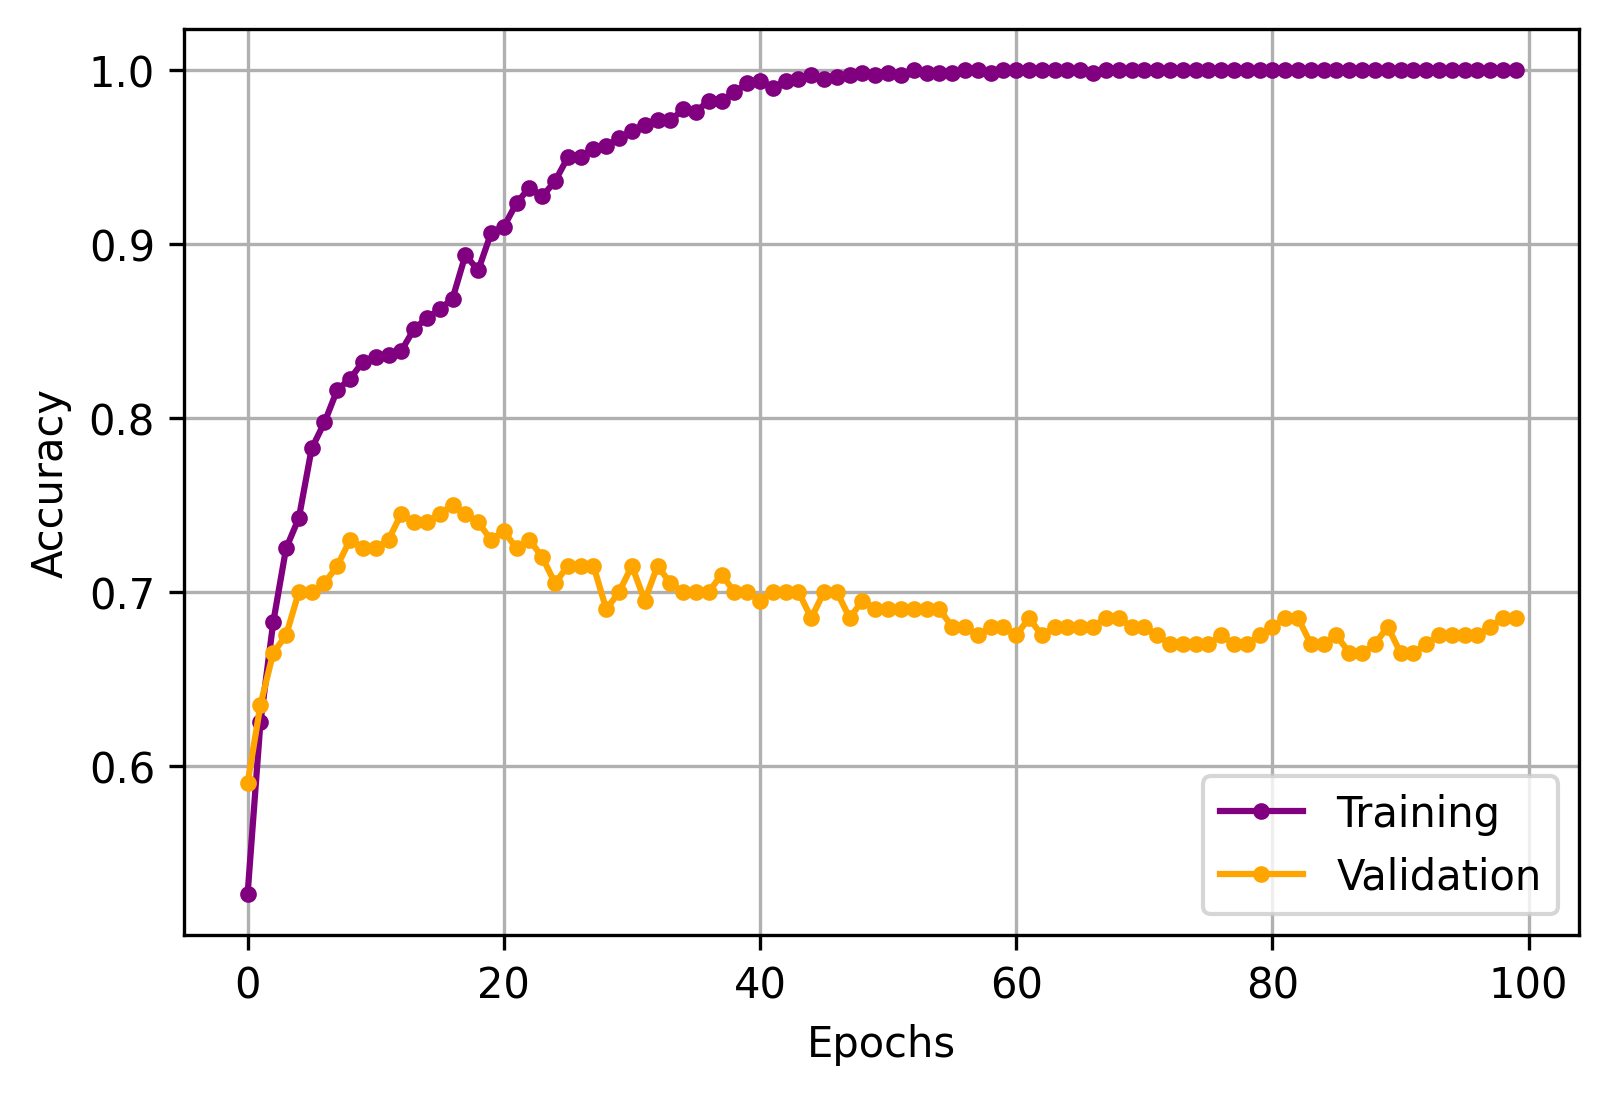

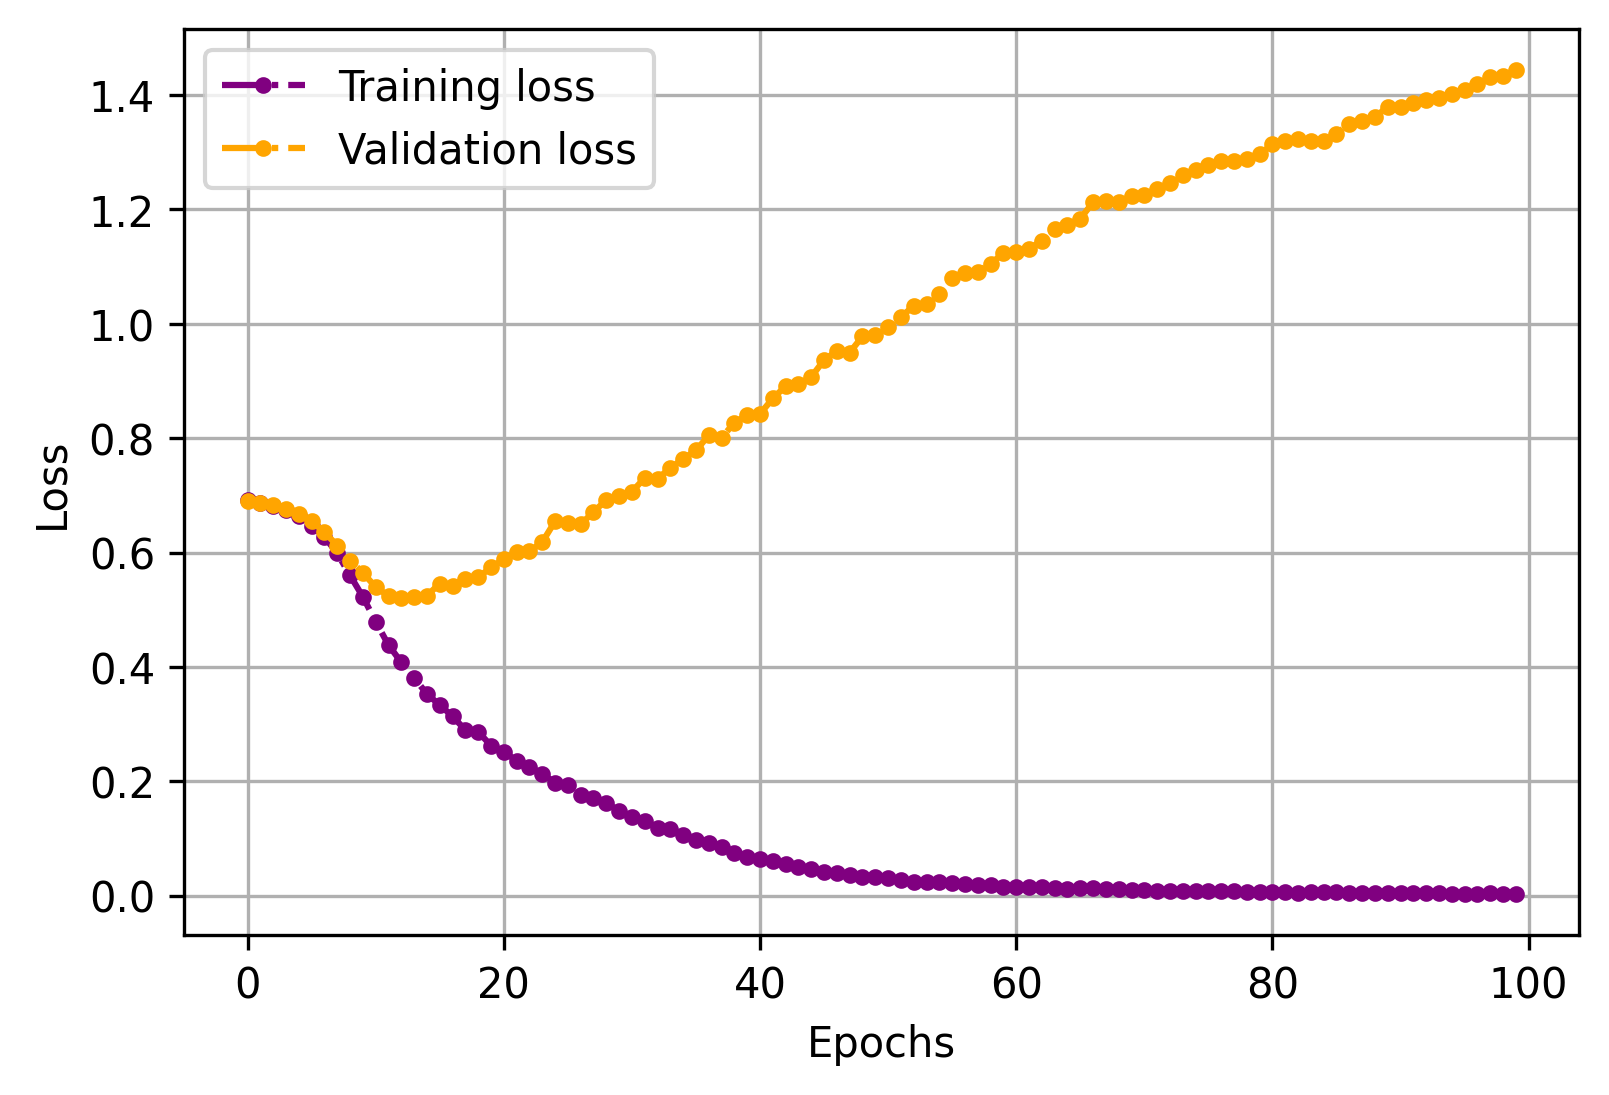

In [35]:
fig, axis = plt.subplots(dpi=300)
axis.plot(training_statistics.history['accuracy'], ls='-', marker='.', label='Training', color='purple')
axis.plot(training_statistics.history['val_accuracy'], ls='-', marker='.', label='Validation', color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()


fig, axis = plt.subplots(dpi=300)
axis.plot(training_statistics.history['loss'], ls='-.', marker='.', label='Training loss', color='purple')
axis.plot(training_statistics.history['val_loss'], ls='-.', marker='.', label='Validation loss', color='orange')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

So it looks like that adding some drop out layer did not help as our statistics is simple to small. Hence let us simulate now 100 k instead of 1 k events per source position:

In [36]:
n_events = 10**5
n_ph = 25
photon_charge_resolution = 0.3
photon_charge_threshold = 0.15  
fraction_training = 0.8

offsets_n, times_n, channel_n, charge_n = neutron_model.generate_events(n_events, 
                                                                        n_ph,
                                                                        photon_charge_resolution,
                                                                        photon_charge_threshold,
                                                                       )

offsets_bkg, times_bkg, channel_bkg, charge_bkg = bkg_model.generate_events(n_events, 
                                                                            n_ph,
                                                                            photon_charge_resolution,
                                                                            photon_charge_threshold,
                                                                           )

# Image creation:
images_n = neutron_model.make_sample(offsets_n, 
                                     times_n, 
                                     channel_n, 
                                     charge_n, 
                                     time_bins=np.arange(0, 32.1, 2)
                                    )
images_bkg = bkg_model.make_sample(offsets_bkg, 
                                   times_bkg, 
                                   channel_bkg, 
                                   charge_bkg, 
                                   time_bins=np.arange(0, 32.1, 2)
                                  )

# Image processing, labeling and splitting:
max_charge_n = np.max(images_n)
images_n /= max_charge_n

max_charge_bkg = np.max(images_bkg)
images_bkg /= max_charge_bkg

assert len(images_n) == len(images_bkg)
n_events = len(images_n)

# Make common image buffer:
images = np.concatenate([images_n, images_bkg])

# Create labels for images:
image_labels = np.zeros((2*n_events, 2), dtype=np.int8)
image_labels[:n_events, 0] = 1
image_labels[n_events:, 1] = 1

# Schuffel:
inds = np.arange(0, 2*n_events, 1)
np.random.shuffle(inds)
images = images[inds]
image_labels = image_labels[inds]

n_training = int(n_events*fraction_training)
images_training = images[:n_training]
labels_training = image_labels[:n_training]

n_valid = n_events - n_training
images_validation = images[-n_valid:]
labels_validation = image_labels[-n_valid:]

In [37]:
my_first_nn = Sequential()
my_first_nn.add(Flatten(input_shape=(20, 16, 1)))
my_first_nn.add(Dense(100, activation='relu'))
my_first_nn.add(Dense(50, activation='relu'))
my_first_nn.add(Dense(2, activation='softmax'))

my_first_nn.compile(loss=keras.losses.binary_crossentropy, 
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy']
                   )


my_first_nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 320)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               32100     
                                                                 
 dense_7 (Dense)             (None, 50)                5050      
                                                                 
 dense_8 (Dense)             (None, 2)                 102       
                                                                 
Total params: 37,252
Trainable params: 37,252
Non-trainable params: 0
_________________________________________________________________


In [38]:
training_statistics = my_first_nn.fit(images_training, 
                                      labels_training, 
                                      batch_size=batch_size, 
                                      epochs=epochs,  
                                      validation_data=(images_validation, labels_validation),
                                     )

Epoch 1/100
625/625 [==============================] - 2s 2ms/step - loss: 0.4716 - accuracy: 0.7743 - val_loss: 0.4268 - val_accuracy: 0.7961
Epoch 2/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4165 - accuracy: 0.8020 - val_loss: 0.4102 - val_accuracy: 0.8091
Epoch 3/100
625/625 [==============================] - 1s 2ms/step - loss: 0.3843 - accuracy: 0.8224 - val_loss: 0.4091 - val_accuracy: 0.8091
Epoch 4/100
625/625 [==============================] - 1s 2ms/step - loss: 0.3528 - accuracy: 0.8407 - val_loss: 0.3995 - val_accuracy: 0.8160
Epoch 5/100
625/625 [==============================] - 1s 2ms/step - loss: 0.3265 - accuracy: 0.8542 - val_loss: 0.4005 - val_accuracy: 0.8188
Epoch 6/100
625/625 [==============================] - 1s 2ms/step - loss: 0.3040 - accuracy: 0.8675 - val_loss: 0.4095 - val_accuracy: 0.8159
Epoch 7/100
625/625 [==============================] - 1s 2ms/step - loss: 0.2871 - accuracy: 0.8755 - val_loss: 0.4141 - val_accuracy: 0.8186

Epoch 58/100
625/625 [==============================] - 1s 2ms/step - loss: 0.1008 - accuracy: 0.9610 - val_loss: 0.9998 - val_accuracy: 0.8084
Epoch 59/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0991 - accuracy: 0.9609 - val_loss: 1.0296 - val_accuracy: 0.8122
Epoch 60/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0980 - accuracy: 0.9614 - val_loss: 1.0707 - val_accuracy: 0.8123
Epoch 61/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0961 - accuracy: 0.9621 - val_loss: 1.0767 - val_accuracy: 0.8119
Epoch 62/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0950 - accuracy: 0.9625 - val_loss: 1.0861 - val_accuracy: 0.8074
Epoch 63/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0932 - accuracy: 0.9630 - val_loss: 1.1099 - val_accuracy: 0.8082
Epoch 64/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0928 - accuracy: 0.9631 - val_loss: 1.1253 - val_accuracy:

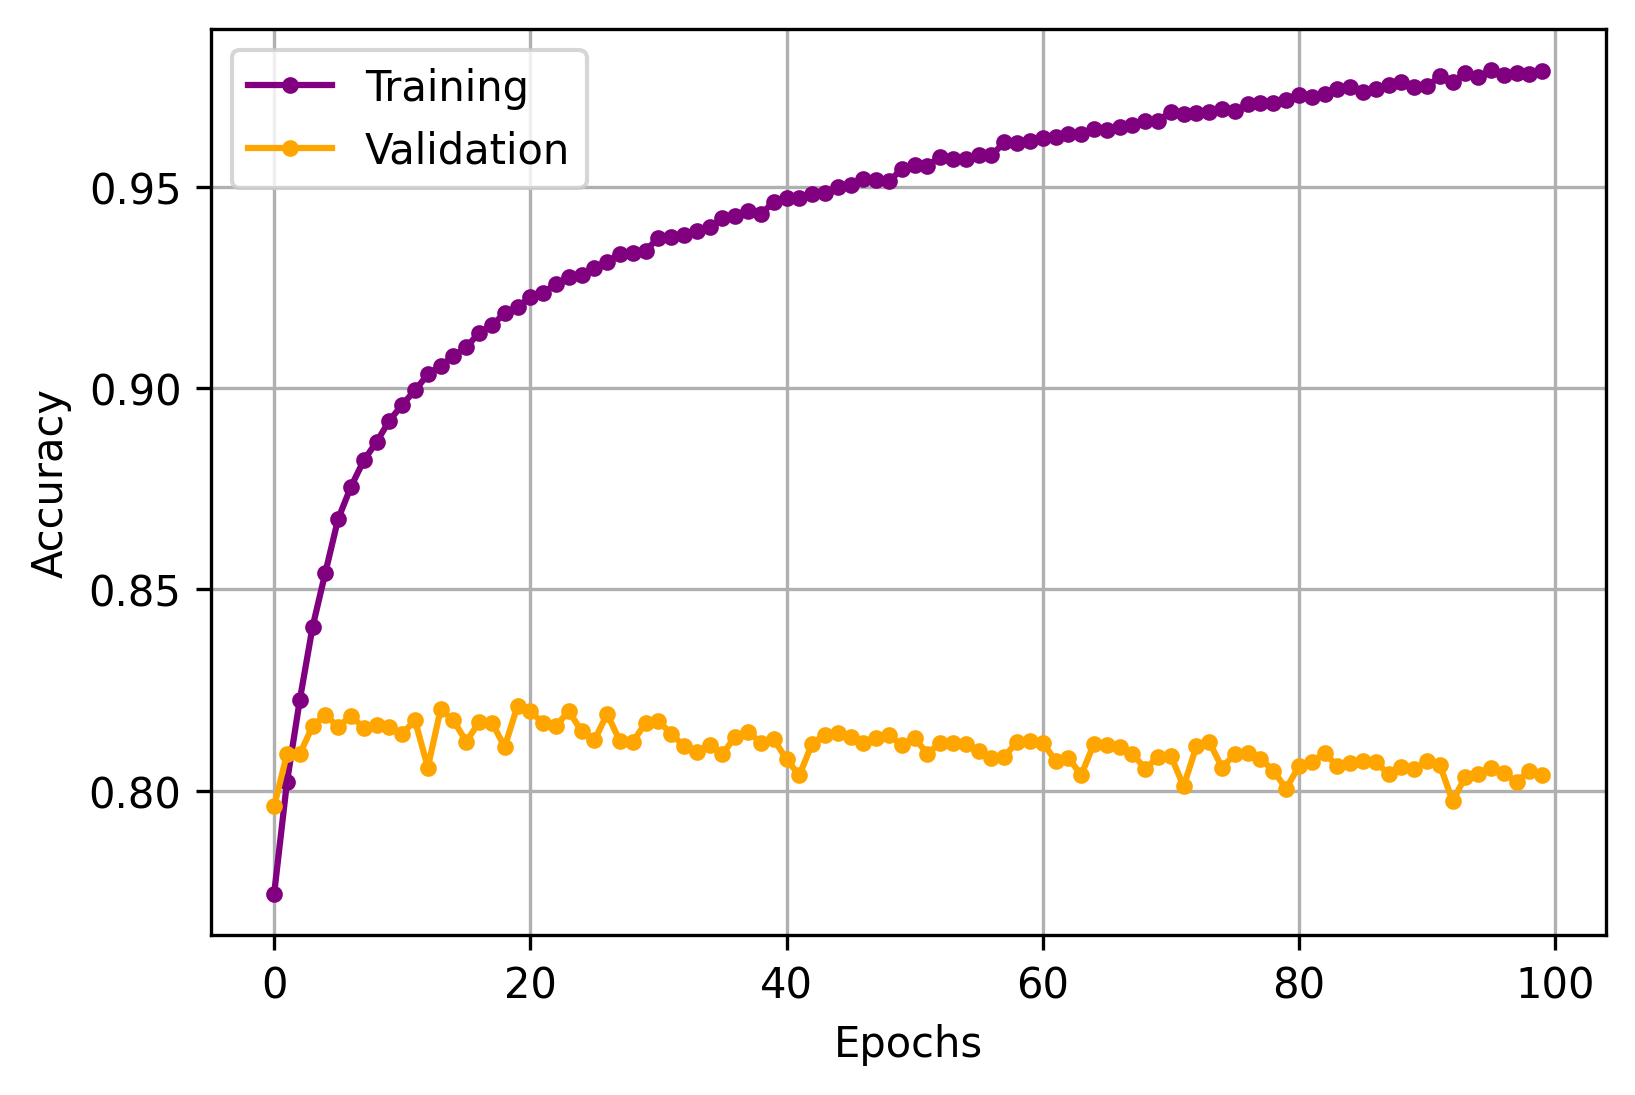

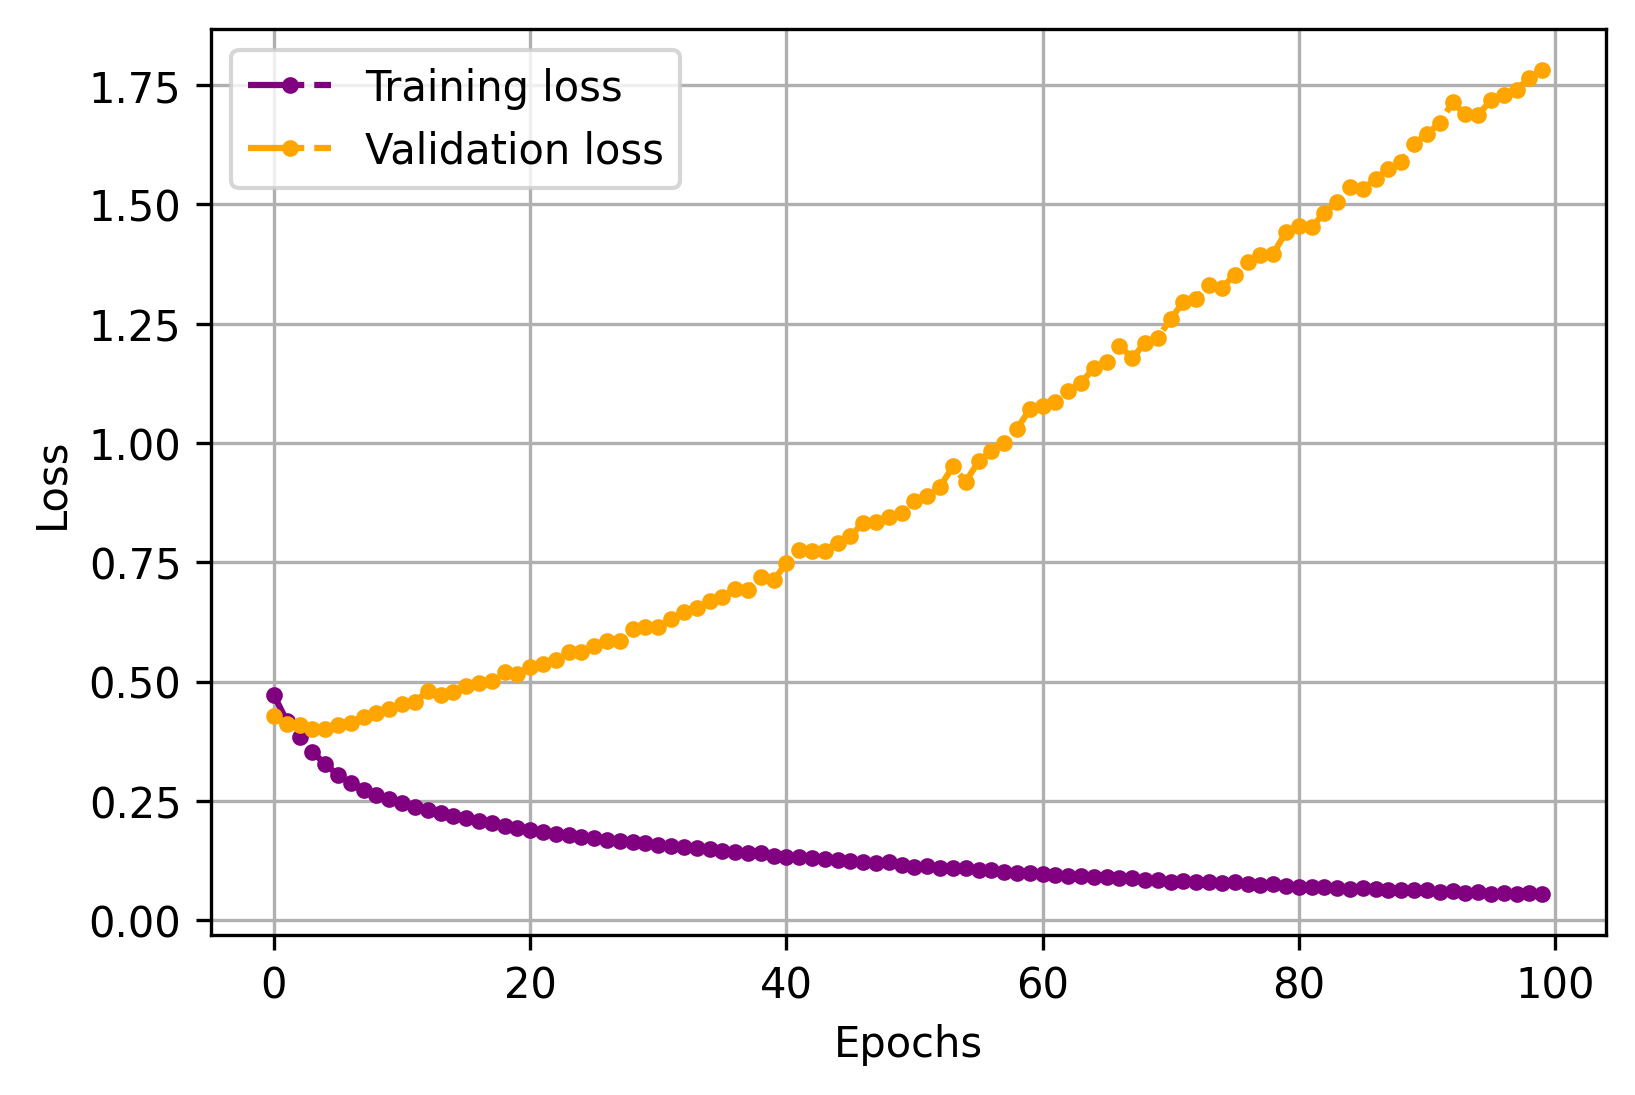

In [39]:
fig, axis = plt.subplots(dpi=300)
axis.plot(training_statistics.history['accuracy'], ls='-', marker='.', label='Training', color='purple')
axis.plot(training_statistics.history['val_accuracy'], ls='-', marker='.', label='Validation', color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()


fig, axis = plt.subplots(dpi=300)
axis.plot(training_statistics.history['loss'], ls='-.', marker='.', label='Training loss', color='purple')
axis.plot(training_statistics.history['val_loss'], ls='-.', marker='.', label='Validation loss', color='orange')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

Also the larger statistics did not lead to a better result. Hence, in this case one would use the model at the point where we reached the minimal validation loss and the highest validation accuracy. So lets see if e can do better with a CNN.

# Moving to Convolutional Neural Networks:

So far we only achieved a validation accuracy of about 80 % let us see if we can do better with a Convolutional Neural Network. As the name suggest CNNs are using convolutions between kernel matrices and images to extract certain features of the image. The idea behind this type of networks can be understood when looking at typical applications in image processing. In image processing specific filter kernels like [Canny edge detection](https://en.wikipedia.org/wiki/Canny_edge_detection) can be used to detect edges in images. In addition the convolution will group together spatially important information. The subsequent image shows an example for convolution in which a 5 x 5 image is convolved with a 3 x 3 kernel filled with only ones:

<img src="images/convolution.png" alt="llustration convolution" style="width: 600px;"/>

Each value of the image is multiplied with the corresponding value of the kernel. Afterwards all values are summed up and stored in a new output image before the kernel is moved further along an axis of the image. As you can see in this simple example the resulting output image will be reduce in its dimensions. This is often not desired and therefore one pads images using for example additional rows and columns of zeros:

<img src="images/convolution_with_padding.png" alt="llustration convolution with padding" style="width: 600px;"/>


Usually the convolution layer is combined with operations like max pooling layers. Max pooling helps to sharpen the image and to extract its most relevant features. Further, max pooling layers are reducing the number of parameters needed in subsequent layers and therefore the overall size of the network. Max pooling works in way that it takes in a certain kernel the maximal image value as illustrated below:

<img src="images/max_pooling.png" alt="llustration max pooling" style="width: 600px;"/>

The general concept is to have multiple layers of convolution and max pooling after another before calling a few densely connected layers. This concept is based on the idea that e.g. in order to recognize a face you have to first learn how to identify lines and contours before you can identify mid-size objects like eyes, mouth and nose and at the very end you can identify entire face. 

So let us now import the required layers from tensorflow. As our problem is a two dimensional one (PMT channel/ azimuthal angle versus time) we have to import the 2D versions of the corresponding algorithms:

In [40]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [41]:
my_cnn_model = Sequential()
my_cnn_model.add(Conv2D(8, (3,3), input_shape=(20, 16, 1), activation='relu', padding='same'))
my_cnn_model.add(MaxPooling2D(2,2))
my_cnn_model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
my_cnn_model.add(MaxPooling2D(2,2))
my_cnn_model.add(Flatten())
my_cnn_model.add(Dense(200, activation='relu'))
my_cnn_model.add(Dense(100, activation='relu'))
my_cnn_model.add(Dense(2, activation='softmax'))
my_cnn_model.compile(loss=keras.losses.binary_crossentropy, 
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy']
                   )
my_cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 16, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 8, 8)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 8, 16)         1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 320)               0         
                                                                 
 dense_9 (Dense)             (None, 200)              

Let train this first CNN with the same data from before and compare the accuracy:

In [42]:
batch_size = 1024
epochs = 30

In [43]:
cnn_statistics = my_cnn_model.fit(images_training, 
                                  labels_training, 
                                  batch_size=batch_size, 
                                  epochs=epochs,  
                                  validation_data=(images_validation, labels_validation),
                                 )

Epoch 1/30
79/79 [==============================] - 7s 81ms/step - loss: 0.5271 - accuracy: 0.7311 - val_loss: 0.3952 - val_accuracy: 0.8189
Epoch 2/30
79/79 [==============================] - 6s 81ms/step - loss: 0.3400 - accuracy: 0.8507 - val_loss: 0.3196 - val_accuracy: 0.8619
Epoch 3/30
79/79 [==============================] - 6s 80ms/step - loss: 0.3098 - accuracy: 0.8669 - val_loss: 0.3083 - val_accuracy: 0.8660
Epoch 4/30
79/79 [==============================] - 6s 81ms/step - loss: 0.3032 - accuracy: 0.8702 - val_loss: 0.3008 - val_accuracy: 0.8704
Epoch 5/30
79/79 [==============================] - 6s 81ms/step - loss: 0.2942 - accuracy: 0.8737 - val_loss: 0.2962 - val_accuracy: 0.8706
Epoch 6/30
79/79 [==============================] - 6s 81ms/step - loss: 0.2889 - accuracy: 0.8766 - val_loss: 0.2916 - val_accuracy: 0.8750
Epoch 7/30
79/79 [==============================] - 6s 81ms/step - loss: 0.2877 - accuracy: 0.8765 - val_loss: 0.2947 - val_accuracy: 0.8713
Epoch 8/30
79

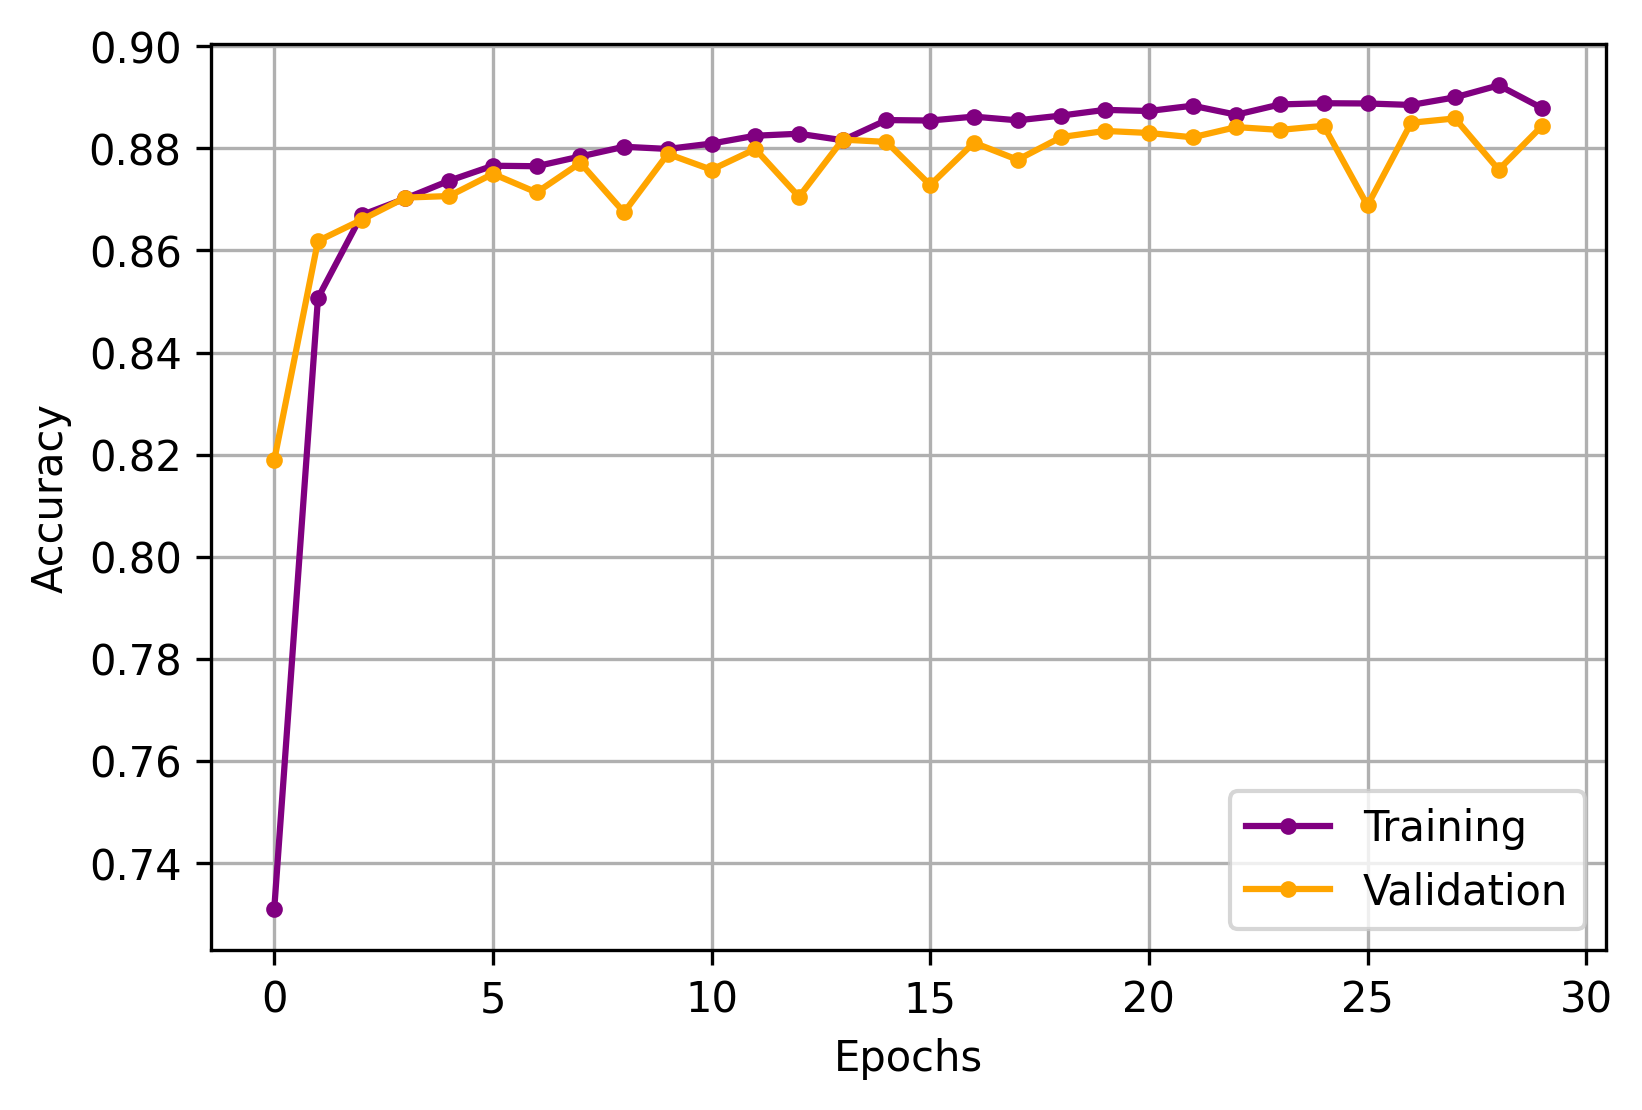

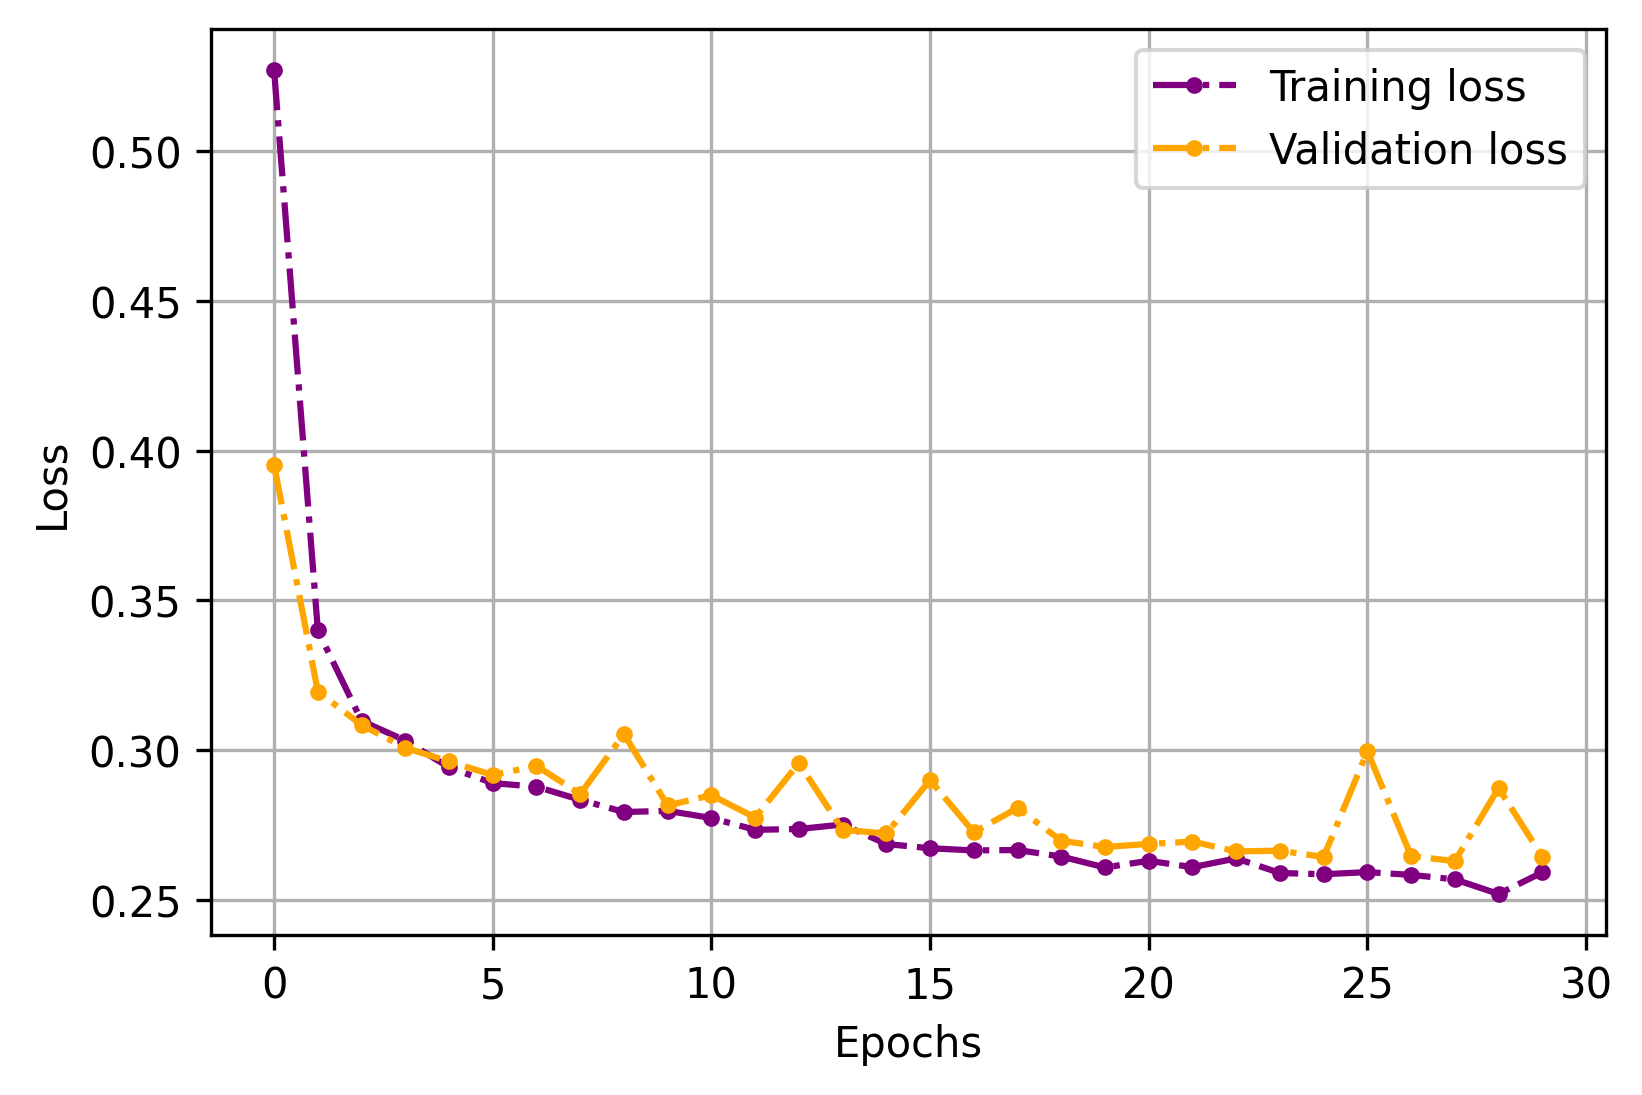

In [44]:
fig, axis = plt.subplots(dpi=300)
axis.plot(cnn_statistics.history['accuracy'], ls='-', marker='.', label='Training', color='purple')
axis.plot(cnn_statistics.history['val_accuracy'], ls='-', marker='.', label='Validation', color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()


fig, axis = plt.subplots(dpi=300)
axis.plot(cnn_statistics.history['loss'], ls='-.', marker='.', label='Training loss', color='purple')
axis.plot(cnn_statistics.history['val_loss'], ls='-.', marker='.', label='Validation loss', color='orange')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

Compared to our simple model we achieve a slightly higher efficiency be using almost the same number of parameters. Once we found and trained our model we can also easily store it to disk via...

In [45]:
my_cnn_model.save('./data/cnn_model_simple_approach.hdf5')

...and load it again with:

In [46]:
my_cnn_model.load_weights('./data/cnn_model_simple_approach.hdf5')

## Callback functions:

Sometimes it is useful to have some more control over the training procedure of our CNNs. You may want to stop training after a fixed amount of time or take checkpoints of your current model weights in case your notebook crashes. For this purpose we can define different callback functions which we can supply. 

Tensorflow also others some already predefined callback functions. Let us have a look at the `ModelCheckpoint` callback function. We can simply define the callback function as:

In [47]:
checkpoint_names = './data/checkpoints/my_cnn_model_check_point_{epoch:04d}.ckpt'


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_names, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=False,
    save_freq=len(images_training)//batch_size//2, 
)




This call back function will now store our model weights twice per epoch. Let compile and retrain our model:

In [48]:
my_cnn_model = Sequential()
my_cnn_model.add(Conv2D(8, (3,3), input_shape=(20, 16, 1), activation='relu'))
my_cnn_model.add(MaxPooling2D(2,2))
my_cnn_model.add(Conv2D(16, (3,3), activation='relu'))
my_cnn_model.add(MaxPooling2D(2,2))
my_cnn_model.add(Flatten())
my_cnn_model.add(Dense(200, activation='relu'))
my_cnn_model.add(Dense(100, activation='relu'))
my_cnn_model.add(Dense(2, activation='softmax'))
my_cnn_model.compile(loss=keras.losses.binary_crossentropy, 
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy']
                   )

In [49]:
cnn_statistics = my_cnn_model.fit(images_training, 
                                  labels_training, 
                                  batch_size=batch_size, 
                                  epochs=epochs,  
                                  validation_data=(images_validation, labels_validation),
                                  callbacks=[cp_callback,]
                                 )

Epoch 1/30
38/79 [=============>................] - ETA: 1s - loss: 0.6648 - accuracy: 0.6212
Epoch 1: saving model to ./data/checkpoints/my_cnn_model_check_point_0001.ckpt
77/79 [============================>.] - ETA: 0s - loss: 0.5998 - accuracy: 0.6801
Epoch 1: saving model to ./data/checkpoints/my_cnn_model_check_point_0001.ckpt
79/79 [==============================] - 5s 53ms/step - loss: 0.5981 - accuracy: 0.6816 - val_loss: 0.4991 - val_accuracy: 0.7545
Epoch 2/30
36/79 [============>.................] - ETA: 1s - loss: 0.4541 - accuracy: 0.7929
Epoch 2: saving model to ./data/checkpoints/my_cnn_model_check_point_0002.ckpt
75/79 [===========================>..] - ETA: 0s - loss: 0.4378 - accuracy: 0.8025
Epoch 2: saving model to ./data/checkpoints/my_cnn_model_check_point_0002.ckpt
79/79 [==============================] - 4s 52ms/step - loss: 0.4372 - accuracy: 0.8027 - val_loss: 0.4166 - val_accuracy: 0.8161
Epoch 3/30
36/79 [============>.................] - ETA: 2s - loss: 0.

79/79 [==============================] - 4s 52ms/step - loss: 0.3218 - accuracy: 0.8593 - val_loss: 0.3612 - val_accuracy: 0.8384
Epoch 19/30
20/79 [======>.......................] - ETA: 2s - loss: 0.3212 - accuracy: 0.8619
Epoch 19: saving model to ./data/checkpoints/my_cnn_model_check_point_0019.ckpt
59/79 [=====================>........] - ETA: 0s - loss: 0.3194 - accuracy: 0.8611
Epoch 19: saving model to ./data/checkpoints/my_cnn_model_check_point_0019.ckpt
79/79 [==============================] - 4s 50ms/step - loss: 0.3185 - accuracy: 0.8612 - val_loss: 0.3307 - val_accuracy: 0.8548
Epoch 20/30
19/79 [======>.......................] - ETA: 2s - loss: 0.3184 - accuracy: 0.8612
Epoch 20: saving model to ./data/checkpoints/my_cnn_model_check_point_0020.ckpt
58/79 [=====================>........] - ETA: 0s - loss: 0.3176 - accuracy: 0.8615
Epoch 20: saving model to ./data/checkpoints/my_cnn_model_check_point_0020.ckpt
79/79 [==============================] - 4s 50ms/step - loss: 0.

To load one of your stored checkpoints you can load the weights just like before via:

In [50]:
my_cnn_model.load_weights('./data/checkpoints/my_cnn_model_check_point_0013.ckpt')

Other then creating many checkpoints you can also set `save_best_only=True` and so only the best model according to our validation data is stored.

Tensorflow also offers us the possibility write our own call backs and stack them together with other call backs. Lets assume we want to monitor the learning time in addition to the already provided learning stats. For this we can write our own little callback function:

In [51]:
import time


class TimerCallback(keras.callbacks.Callback):
    """Simple callback function which will time the training procedure.
    Based on the tensorflow example which can be found in
    https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
    """

    def on_train_begin(self, logs=None):
        self.epoch_starts = []
        self.epoch_ends = []
        self.training_starts_at = time.time()
        
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_starts.append(time.time()-self.training_starts_at)
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_ends.append(time.time()-self.training_starts_at)
    

Lets use it together again with the checkpoint callback:

In [53]:
checkpoint_names = './data/checkpoints/my_cnn_model_best_check_point.ckpt'

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_names, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True,
)

my_cnn_model = Sequential()
my_cnn_model.add(Conv2D(8, (3,3), input_shape=(20, 16, 1), activation='relu', padding='same'))
my_cnn_model.add(MaxPooling2D(2,2))
my_cnn_model.add(Conv2D(16, (3,3), input_shape=(20, 16, 1), activation='relu', padding='same'))
my_cnn_model.add(MaxPooling2D(2,2))
my_cnn_model.add(Flatten())
my_cnn_model.add(Dense(200, activation='relu'))
my_cnn_model.add(Dense(100, activation='relu'))
my_cnn_model.add(Dense(2, activation='softmax'))
my_cnn_model.compile(loss=keras.losses.binary_crossentropy, 
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy']
                   )

In [54]:
epochs=10

In [55]:
my_timer_callback = TimerCallback()

cnn_statistics = my_cnn_model.fit(images_training, 
                                  labels_training, 
                                  batch_size=batch_size, 
                                  epochs=epochs,  
                                  validation_data=(images_validation, labels_validation),
                                  callbacks=[cp_callback, my_timer_callback]
                                 )

Epoch 1/10
78/79 [============================>.] - ETA: 0s - loss: 0.5295 - accuracy: 0.7263
Epoch 1: val_loss improved from inf to 0.41209, saving model to ./data/checkpoints/my_cnn_model_best_check_point.ckpt
79/79 [==============================] - 7s 82ms/step - loss: 0.5292 - accuracy: 0.7265 - val_loss: 0.4121 - val_accuracy: 0.8146
Epoch 2/10
78/79 [============================>.] - ETA: 0s - loss: 0.3752 - accuracy: 0.8314
Epoch 2: val_loss improved from 0.41209 to 0.35261, saving model to ./data/checkpoints/my_cnn_model_best_check_point.ckpt
79/79 [==============================] - 7s 83ms/step - loss: 0.3750 - accuracy: 0.8315 - val_loss: 0.3526 - val_accuracy: 0.8460
Epoch 3/10
78/79 [============================>.] - ETA: 0s - loss: 0.3306 - accuracy: 0.8570
Epoch 3: val_loss improved from 0.35261 to 0.32515, saving model to ./data/checkpoints/my_cnn_model_best_check_point.ckpt
79/79 [==============================] - 6s 79ms/step - loss: 0.3305 - accuracy: 0.8570 - val_lo

/tmp/jobs/19227307/ipykernel_2591/1861357155.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis2.set_xticklabels([f'{t:.2f}' for t in my_timer_callback.epoch_starts],


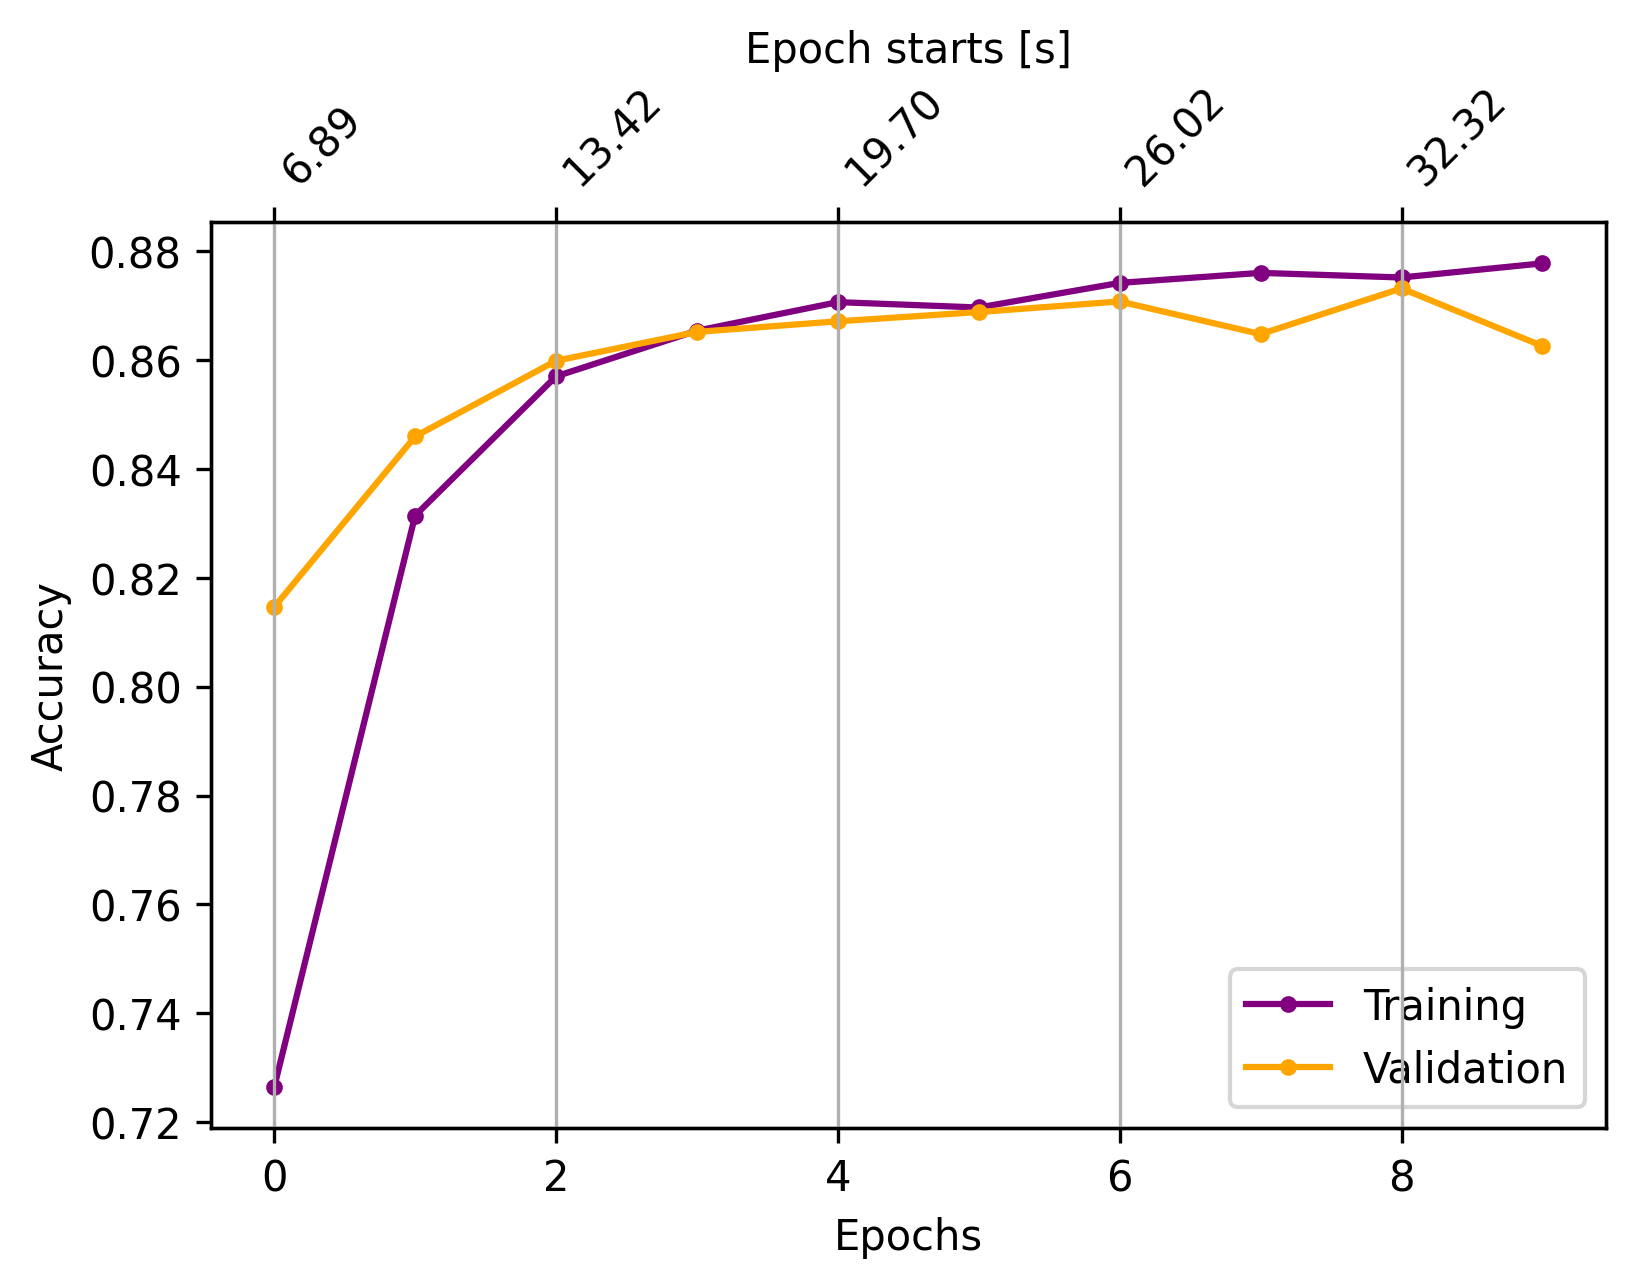

In [56]:
fig, axis = plt.subplots(dpi=300)
axis.plot(cnn_statistics.history['accuracy'], ls='-', marker='.', label='Training', color='purple')
axis.plot(cnn_statistics.history['val_accuracy'], ls='-', marker='.', label='Validation', color='orange')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

axis2 = axis.twiny()
axis2.set_xlim(*axis.get_xlim())
axis2.set_xticklabels([f'{t:.2f}' for t in my_timer_callback.epoch_starts], 
                      rotation=45, horizontalalignment='left')
plt.xlabel('Epoch starts [s]')

plt.grid()


# More complex model:


So far we only used a fairly simple CNN model. If you are moving towards real applications models can become quite complex and it makes a lot of sense to store your model in a single function rather then copy-pasting it all the time. In addition you may need to add your own custom layers to your CNN model.

In this last section we will have a look into exactly this. Lets start with building more complex models based on our previous example:

```python
my_cnn_model = Sequential()
my_cnn_model.add(Conv2D(8, (3,3), input_shape=(20, 16, 1), activation='relu'))
my_cnn_model.add(MaxPooling2D(2,2))
my_cnn_model.add(Conv2D(16, (3,3), activation='relu'))
my_cnn_model.add(MaxPooling2D(2,2))
my_cnn_model.add(Flatten())
my_cnn_model.add(Dense(200, activation='relu'))
my_cnn_model.add(Dense(100, activation='relu'))
my_cnn_model.add(Dense(2, activation='softmax'))
```

In our previous example we used two times a convolution and max pooling layer before using dense layers to compute the classification. Lets build first a new custom layer which always combines convolution and max pooling layer.

In [57]:
class MyConvLayers(tf.keras.layers.Layer):
    """My custom made convolution layer. It combines a convolution layer
    with a MaxPooling layer.
    """
    def __init__(self, n_kernal, kernal_size, padding='same'):
        super(MyConvLayers, self).__init__()
        self.n_kernal = n_kernal
        self.kernal_size = kernal_size
        self.padding = padding
    
    def build(self, input_shape):       
        self.conv = Conv2D(self.n_kernal,
                           self.kernal_size,
                           input_shape=input_shape,
                           padding=self.padding,
                           activation='relu',
                          )
        self.maxp = MaxPooling2D((2, 2))
        
    def call(self, input_tensor):
        tensor = self.conv(input_tensor)
        tensor = self.maxp(tensor)
        return tensor

Now we can add this new layer to our model as we are used to. But let us add this time one additional layer.

In [58]:
t = Sequential()
t.add(tf.keras.layers.InputLayer(input_shape=(20, 16, 1)))
t.add(MyConvLayers(8, 3))
t.add(MyConvLayers(16, 3))
t.add(MyConvLayers(32, 3))
t.add(Flatten())
t.add(Dense(200, activation='relu'))
t.add(Dense(100, activation='relu'))
t.add(Dense(2, activation='softmax'))
t.compile(loss=keras.losses.binary_crossentropy, 
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy'])
t.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_conv_layers (MyConvLayer  (None, 10, 8, 8)         80        
 s)                                                              
                                                                 
 my_conv_layers_1 (MyConvLay  (None, 5, 4, 16)         1168      
 ers)                                                            
                                                                 
 my_conv_layers_2 (MyConvLay  (None, 2, 2, 32)         4640      
 ers)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 200)               25800     
                                                      

As you can see from the summary printout the output dimensions of the first two layer are similar to the outputs of the first two max pooling layers in our previous models. By adding the additional convolution + max pooling layer we reduce the number of parameters quite a bit. So let us try to train this model again and see what happens:

In [59]:
cnn_statistics = t.fit(images_training, 
                       labels_training, 
                       batch_size=batch_size, 
                       epochs=epochs,  
                       validation_data=(images_validation, labels_validation),
                      )

Epoch 1/10
79/79 [==============================] - 8s 96ms/step - loss: 0.5426 - accuracy: 0.7222 - val_loss: 0.4275 - val_accuracy: 0.8057
Epoch 2/10
79/79 [==============================] - 7s 92ms/step - loss: 0.3861 - accuracy: 0.8298 - val_loss: 0.3573 - val_accuracy: 0.8444
Epoch 3/10
79/79 [==============================] - 7s 91ms/step - loss: 0.3379 - accuracy: 0.8525 - val_loss: 0.3523 - val_accuracy: 0.8482
Epoch 4/10
79/79 [==============================] - 7s 92ms/step - loss: 0.3230 - accuracy: 0.8598 - val_loss: 0.3203 - val_accuracy: 0.8616
Epoch 5/10
79/79 [==============================] - 7s 92ms/step - loss: 0.3019 - accuracy: 0.8700 - val_loss: 0.3057 - val_accuracy: 0.8673
Epoch 6/10
79/79 [==============================] - 7s 92ms/step - loss: 0.2927 - accuracy: 0.8737 - val_loss: 0.3277 - val_accuracy: 0.8554
Epoch 7/10
79/79 [==============================] - 7s 92ms/step - loss: 0.2860 - accuracy: 0.8769 - val_loss: 0.2864 - val_accuracy: 0.8769
Epoch 8/10
79

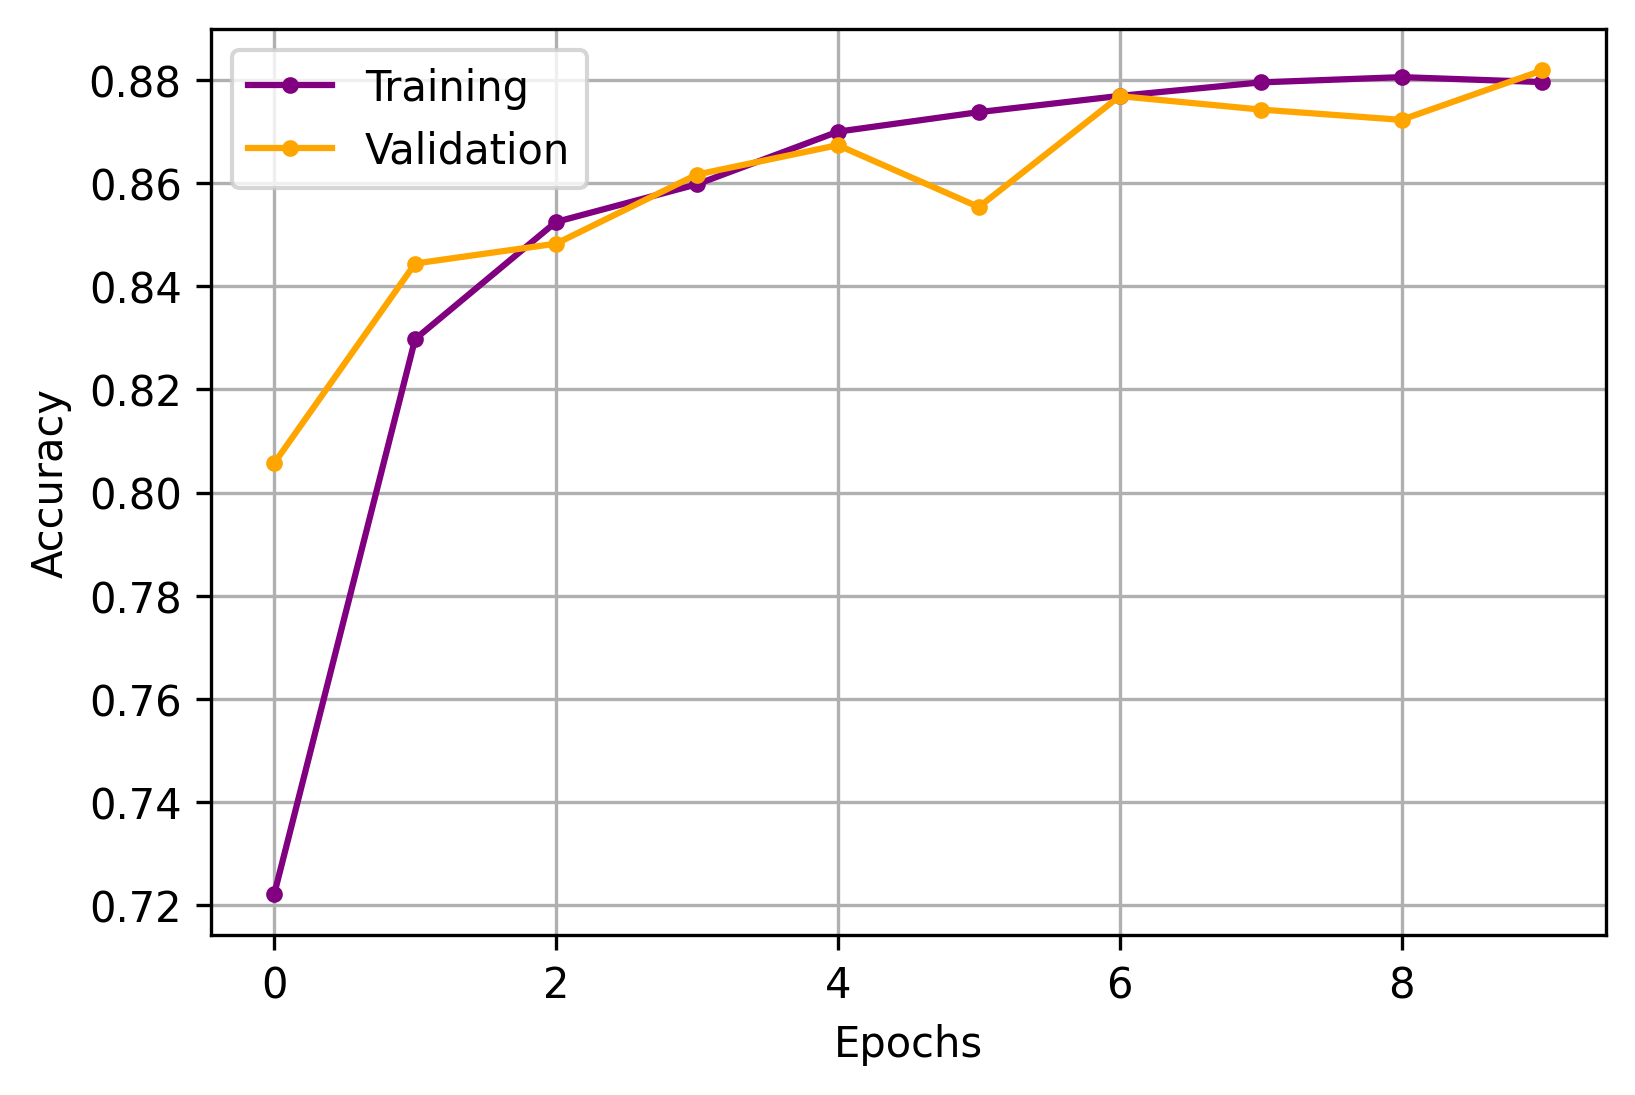

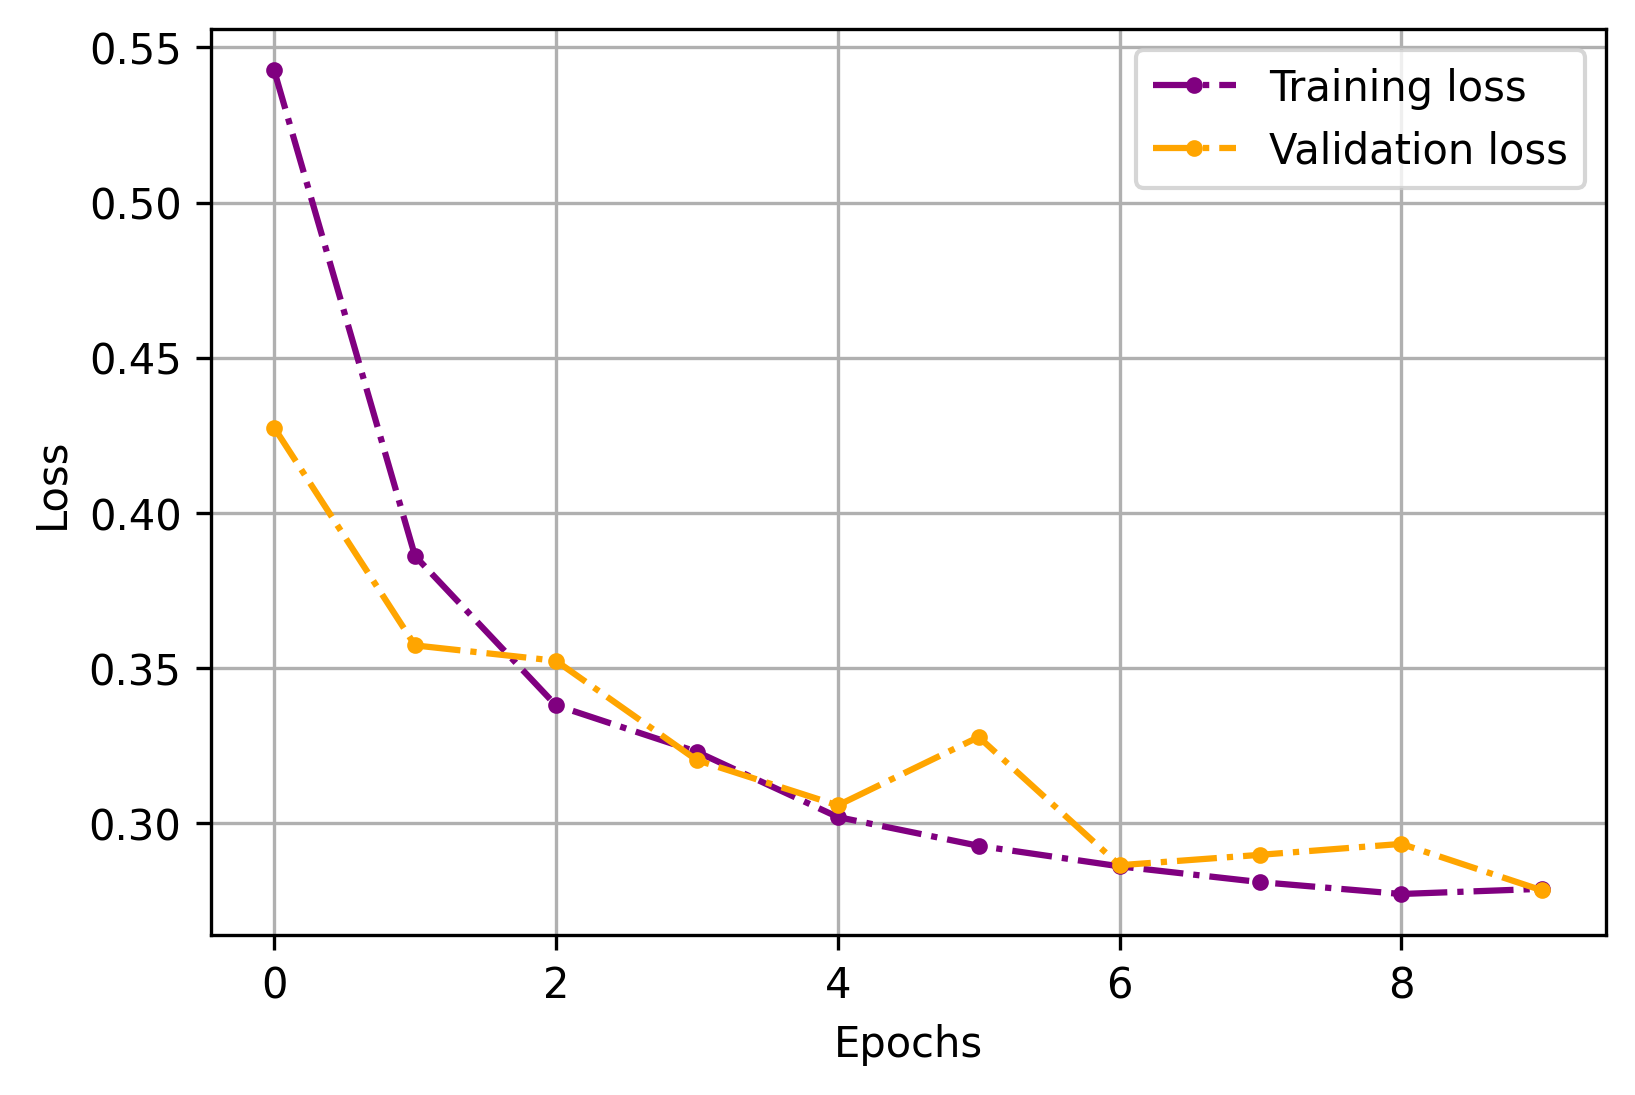

In [60]:
fig, axis = plt.subplots(dpi=300)
axis.plot(cnn_statistics.history['accuracy'], ls='-', marker='.', label='Training', color='purple')
axis.plot(cnn_statistics.history['val_accuracy'], ls='-', marker='.', label='Validation', color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()


fig, axis = plt.subplots(dpi=300)
axis.plot(cnn_statistics.history['loss'], ls='-.', marker='.', label='Training loss', color='purple')
axis.plot(cnn_statistics.history['val_loss'], ls='-.', marker='.', label='Validation loss', color='orange')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

So it looks like that even with this reduced set of parameters we can still achieve almost the same accuracy as before which is nice. 

One thing which is still a bit annoying is the fact that we have to copy paste always our entire model. We just learned how to create a new layer as a subclass of tensorflows layer class. Now we can combine our new layers in a simple function call to define our model:

In [61]:
# First let us create also an additional layer class for the classifcation layers
# for convienience:
class MyClassifcationLayers(tf.keras.layers.Layer):
    
    def __init__(self, n_classes):
        super(MyClassifcationLayers, self).__init__()
        self.n_classes = n_classes
    
    def build(self, input_shape):       
        self.flatten = Flatten()
        self.dense1 = Dense(200, activation='relu')
        self.dense2 = Dense(100, activation='relu')
        self.dense_output = Dense(self.n_classes, activation='softmax')
        
    def call(self, input_tensor):
        tensor = self.flatten(input_tensor)
        tensor = self.dense1(tensor)
        tensor = self.dense2(tensor)
        tensor = self.dense_output(tensor)
        return tensor




def my_sequential_model():
    model = Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(20, 16, 1)))
    model.add(MyConvLayers(8, 3))
    model.add(MyConvLayers(16, 3))
    model.add(MyConvLayers(32, 3))
    model.add(MyClassifcationLayers(2))
    model.compile(loss=keras.losses.binary_crossentropy, 
                        optimizer=keras.optimizers.Adam(),
                        metrics=['accuracy'])
    return model

In [62]:
t = my_sequential_model()
t.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_conv_layers_3 (MyConvLay  (None, 10, 8, 8)         80        
 ers)                                                            
                                                                 
 my_conv_layers_4 (MyConvLay  (None, 5, 4, 16)         1168      
 ers)                                                            
                                                                 
 my_conv_layers_5 (MyConvLay  (None, 2, 2, 32)         4640      
 ers)                                                            
                                                                 
 my_classifcation_layers (My  (None, 2)                46102     
 ClassifcationLayers)                                            
                                                                 
Total params: 51,990
Trainable params: 51,990
Non-trai

Once defined you can even change and modify the layer structure afterwards if you like:

In [63]:
t.layers

## Circular Padding and a more complex model:

We learned already quite a lot up to this point and we can start building more complex data and models. So far we have only considered one point of emission for the neutrons and our source. But in reality light can be emitted from everywhere near the cryostat and near the PMTs. However, there will be an issue when we move around the cryostat. Take for example the point [0, 90, 0] instead of [0, -90, 0].

In [64]:
emission_point = np.array([[0, 90, 0]])
neutron_model = NeutronVetoToyLightPropagator(
    81.5, 
    pmts_in_z_slice,
    emission_point,
)

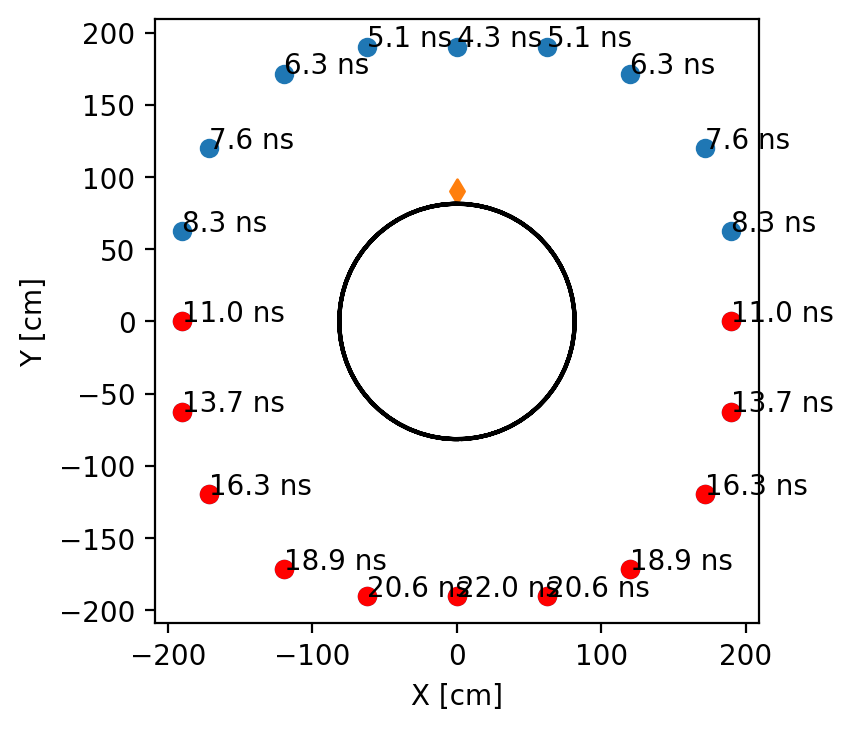

In [65]:
fig = neutron_model.plot_light_propagation(0)
fig.set_dpi(200)
fig

Creating again the corresponding hit-pattern shows that our light cone is shifted by an angle of 180° with respect to our previous images:

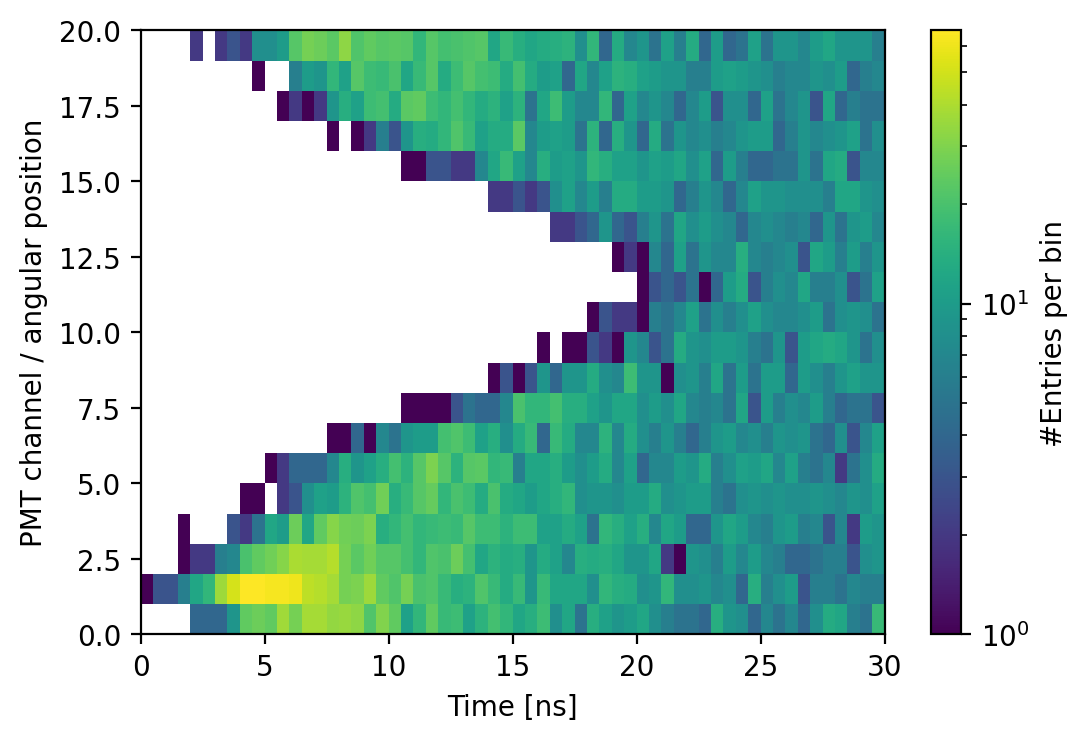

In [66]:
n_events = 10**3
n_photons_per_event = 26
spread_charge_distribtuion = 0.3
lowest_charge_allowed = 0.15


offsets_n, times_n, channel_n, areas_n = neutron_model.generate_events(n_events, 
                                                                       n_photons_per_event, 
                                                                       spread_charge_distribtuion, 
                                                                       lowest_charge_allowed)
n_ph_per_source_n = np.sum(offsets_n, axis=1)

plt.figure(dpi=200)
plt.hist2d(times_n, 
           channel_n,
           bins=(60, 20), range=((0, 30), (0, 20)),
           norm=matplotlib.colors.LogNorm()
          )
plt.colorbar(label='#Entries per bin')
plt.xlabel('Time [ns]')
plt.ylabel('PMT channel / angular position')
plt.show()

Hence, if we use the convolution layers in the same way as we did before we lose information as the upper most and lowest pixel row would be logical disconnected.  To prevent this issue we have to develop our own padding function. So far we padded our data only with zeros to preserve the shape of our image. However now we have to build a custom padding layer which will use a circular padding for the angular position and the regular zero padding for the time axis. 

Developing a custom layer with tensor mathematics can be quite confusing especially if one never worked with the underlying tensor structure. 

To get a better understanding of the tensor shapes let us use two test images:

In [67]:
test_images = np.array([
    [[1,2,3, 1],
     [4,5,6, 4],
     [7,8,9, 7],
    ], 
    [[11, 12, 13, 11],
     [14, 15, 16, 14],
     [17, 18, 19, 17],]])
test_images.shape

(2, 3, 4)

Both images have a height of 3 pixel rows a width of 4 pixels. As "color" or "channel" information both images just carry a single value per pixel. Hence, when asking for the shape we get what we are used to with numpy 

```
  (2, 3, 4) -> (#images, #row, #pixel per row)
```

Lets see what happens when we load these two images into our tensorflow model. How does the underlying ["tensor"](https://www.tensorflow.org/guide/tensor)/matrix look like:

In [68]:
test_model = Sequential()
test_model.add(tf.keras.layers.InputLayer(input_shape=(3, 4, 1)))

In [69]:
test_tensors = test_model(test_images)
test_tensors.shape

TensorShape([2, 3, 4, 1])

When creating a tensor, tensorflow reshapes our image arrays and adds an additional dimensions for the "channel" information. This is necessary as due to convolution layers we will get additional channels, depending on the number of kernels used during the convolution procedure. 

In general the shape of a tensor created from a two dimensional images is given by a tensor/matrix of rank 4. The "rank" refers to the number of dimensions. Where the dimensions represent:

1. batch size (#number of images)
2. image height 
3. image width
4. number of channels.

Since in our previous model we did not fix the batch size during model creating it is represented as `None` in the model summary.

Let us now try to develop an algorithm which allows circular padding. Lets assume that we would like to pad our input image with two additional columns/rows on each side of the image. For this purpose we can use tensorflows in build padding function. However, since the function does not support to perform a circular padding in one dimension we only pad our data along the time dimension for now:

In [70]:
padding_left = 2
padding_right = 2
padding_top = 2
padding_bottom = 2

padded = tf.pad(test_tensors, ((0,0), 
                               (0, 0), 
                               (padding_left, padding_right), 
                               (0, 0))
               )
padded

<tf.Tensor: shape=(2, 3, 8, 1), dtype=float32, numpy=
array([[[[ 0.],
         [ 0.],
         [ 1.],
         [ 2.],
         [ 3.],
         [ 1.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 4.],
         [ 5.],
         [ 6.],
         [ 4.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 7.],
         [ 8.],
         [ 9.],
         [ 7.],
         [ 0.],
         [ 0.]]],


       [[[ 0.],
         [ 0.],
         [11.],
         [12.],
         [13.],
         [11.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [14.],
         [15.],
         [16.],
         [14.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [17.],
         [18.],
         [19.],
         [17.],
         [ 0.],
         [ 0.]]]], dtype=float32)>

In [71]:
padded.shape

TensorShape([2, 3, 8, 1])

By adding the two additional columns on both sides the width changed to 8. This was the easy part. The circular padding is more tricky. There are two reasons for that:
1. Tensors do not allow any item assignment. In general this problem could be circumvented by converting the tensors to numpy arrays before converting them back. This however does not help with the second issue:
2. Lazy batch sizes. In our example above the batch size of our images were set 2, because we had two test images. However, when creating models we usually use a "lazy" batch size which means the first dimension is not defined before run time. Therefore, it is not possible to create a numpy array of the desired size before run time. 

Hence, we have to be a bit more creative here. Instead of creating a new tensor or array which we assign items to we use tensorflows in build concat function to concatenate the desired arrays:

In [72]:
top_pad = padded[:, -padding_top:, :, :]
bottom_pad = padded[:, :padding_bottom, :, :]
circ = tf.concat((top_pad, padded, bottom_pad), axis=1)
circ

<tf.Tensor: shape=(2, 7, 8, 1), dtype=float32, numpy=
array([[[[ 0.],
         [ 0.],
         [ 4.],
         [ 5.],
         [ 6.],
         [ 4.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 7.],
         [ 8.],
         [ 9.],
         [ 7.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 1.],
         [ 2.],
         [ 3.],
         [ 1.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 4.],
         [ 5.],
         [ 6.],
         [ 4.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 7.],
         [ 8.],
         [ 9.],
         [ 7.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 1.],
         [ 2.],
         [ 3.],
         [ 1.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 4.],
         [ 5.],
         [ 6.],
         [ 4.],
         [ 0.],
         [ 0.]]],


       [[[ 0.],
         [ 0.],
  

In [73]:
circ.shape

TensorShape([2, 7, 8, 1])

Which gives the desired result. There are other functions like `tf.stack` which can be used for similar operations.

Since our output shows now the expected circular padding for the azimuthal information and the zero padding the time dimension, let us try to convert everything into a new layer:

In [74]:
class CircularPaddingLayer(tf.keras.layers.Layer):
    """Layer which performs a circular padding along the angular axis
    and uses the specified padding along the time axis.
    """
    def __init__(self, 
                 filter_height, 
                 filter_width,
                 stride_height=1,
                 stride_width=1,
                 **kwargs):
        super(CircularPaddingLayer, self).__init__(**kwargs)
        self.filter_height = filter_height
        self.filter_width = filter_width
        self.stride_height = stride_height
        self.stride_width = stride_width
        

    def build(self, input_shape):
        self._input_shape = input_shape
        _, self._in_height,  self._in_width, _  = input_shape
        # Compute padding boundaries (taken from tensorflow documentation.) 
        if (self._in_height % self.stride_height == 0):
            pad_along_height = max(self.filter_height - self.stride_height, 0)
        else:
            pad_along_height = max(self.filter_height - (self._in_height % self.stride_height), 0)
        if (self._in_width % self.stride_width == 0):
            pad_along_width = max(self.filter_width - self.stride_width, 0)
        else:
            pad_along_width = max(self.filter_width - (self._in_width % self.stride_width), 0)
            
        self.pad_top = pad_along_height // 2
        self.pad_bottom = pad_along_height - self.pad_top
        self.pad_left = pad_along_width // 2
        self.pad_right = pad_along_width - self.pad_left

    def call(self, inputs):
        padded = tf.pad(inputs, ((0,0), 
                               (0, 0), 
                               (self.pad_left, self.pad_right), 
                               (0, 0))
               )
        top_pad = padded[:, -self.pad_top:, :, :]
        bottom_pad = padded[:, :self.pad_bottom, :, :]
        circular_padded = tf.concat((top_pad, padded, bottom_pad), axis=1)
        return circular_padded

Lets try it once more for our custom images:

In [75]:
test_model = Sequential()
test_model.add(tf.keras.layers.InputLayer(input_shape=(3, 4, 1)))
test_model.add(CircularPaddingLayer(3,3))
test_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circular_padding_layer (Cir  (None, 5, 6, 1)          0         
 cularPaddingLayer)                                              
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [76]:
test_model(test_tensors)

<tf.Tensor: shape=(2, 5, 6, 1), dtype=float32, numpy=
array([[[[ 0.],
         [ 7.],
         [ 8.],
         [ 9.],
         [ 7.],
         [ 0.]],

        [[ 0.],
         [ 1.],
         [ 2.],
         [ 3.],
         [ 1.],
         [ 0.]],

        [[ 0.],
         [ 4.],
         [ 5.],
         [ 6.],
         [ 4.],
         [ 0.]],

        [[ 0.],
         [ 7.],
         [ 8.],
         [ 9.],
         [ 7.],
         [ 0.]],

        [[ 0.],
         [ 1.],
         [ 2.],
         [ 3.],
         [ 1.],
         [ 0.]]],


       [[[ 0.],
         [17.],
         [18.],
         [19.],
         [17.],
         [ 0.]],

        [[ 0.],
         [11.],
         [12.],
         [13.],
         [11.],
         [ 0.]],

        [[ 0.],
         [14.],
         [15.],
         [16.],
         [14.],
         [ 0.]],

        [[ 0.],
         [17.],
         [18.],
         [19.],
         [17.],
         [ 0.]],

        [[ 0.],
         [11.],
         [12.],
         [13.]

Everything looks like expect to keep the same image size for a 3 x 3 convolution we need one additional row/column. Now we can build the new model. Please note that we had to switch the `padding` of our `MyConvLayers` to `valid` before adding the new layers.

In [77]:
def my_sequential_model_circ_padding():
    model = Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(20, 16, 1)))
    model.add(CircularPaddingLayer(3,3))
    model.add(MyConvLayers(8, 3, padding='valid'))
    model.add(CircularPaddingLayer(3,3))
    model.add(MyConvLayers(16, 3, padding='valid'))
    model.add(CircularPaddingLayer(3,3))
    model.add(MyConvLayers(32, 3, padding='valid'))
    model.add(MyClassifcationLayers(2))
    model.compile(loss=keras.losses.binary_crossentropy, 
                        optimizer=keras.optimizers.Adam(),
                        metrics=['accuracy'])
    return model

Comparing the two model summaries...

In [78]:
model = my_sequential_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_conv_layers_6 (MyConvLay  (None, 10, 8, 8)         80        
 ers)                                                            
                                                                 
 my_conv_layers_7 (MyConvLay  (None, 5, 4, 16)         1168      
 ers)                                                            
                                                                 
 my_conv_layers_8 (MyConvLay  (None, 2, 2, 32)         4640      
 ers)                                                            
                                                                 
 my_classifcation_layers_1 (  (None, 2)                46102     
 MyClassifcationLayers)                                          
                                                                 
Total params: 51,990
Trainable params: 51,990
Non-tra

In [79]:
circ_model = my_sequential_model_circ_padding()
circ_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circular_padding_layer_1 (C  (None, 22, 18, 1)        0         
 ircularPaddingLayer)                                            
                                                                 
 my_conv_layers_9 (MyConvLay  (None, 10, 8, 8)         80        
 ers)                                                            
                                                                 
 circular_padding_layer_2 (C  (None, 12, 10, 8)        0         
 ircularPaddingLayer)                                            
                                                                 
 my_conv_layers_10 (MyConvLa  (None, 5, 4, 16)         1168      
 yers)                                                           
                                                                 
 circular_padding_layer_3 (C  (None, 7, 6, 16)       

... shows that the output shapes for the `my_conv_layers_XX` layers are still the same.

Let us now create some test data which is distributed on a circle around the detector. We will use in this example 200 randomly distributed source points:

In [80]:
from tools import get_random_cyrcle_position
from simulator.toy_mc import plt_tpc_circle

In [81]:
n_source_points = 200
neutron_x, neutron_y = get_random_cyrcle_position(81.5+15, n_source_points)
gamma_x, gamma_y = get_random_cyrcle_position(180, n_source_points)

Text(0, 0.5, 'Y [cm]')

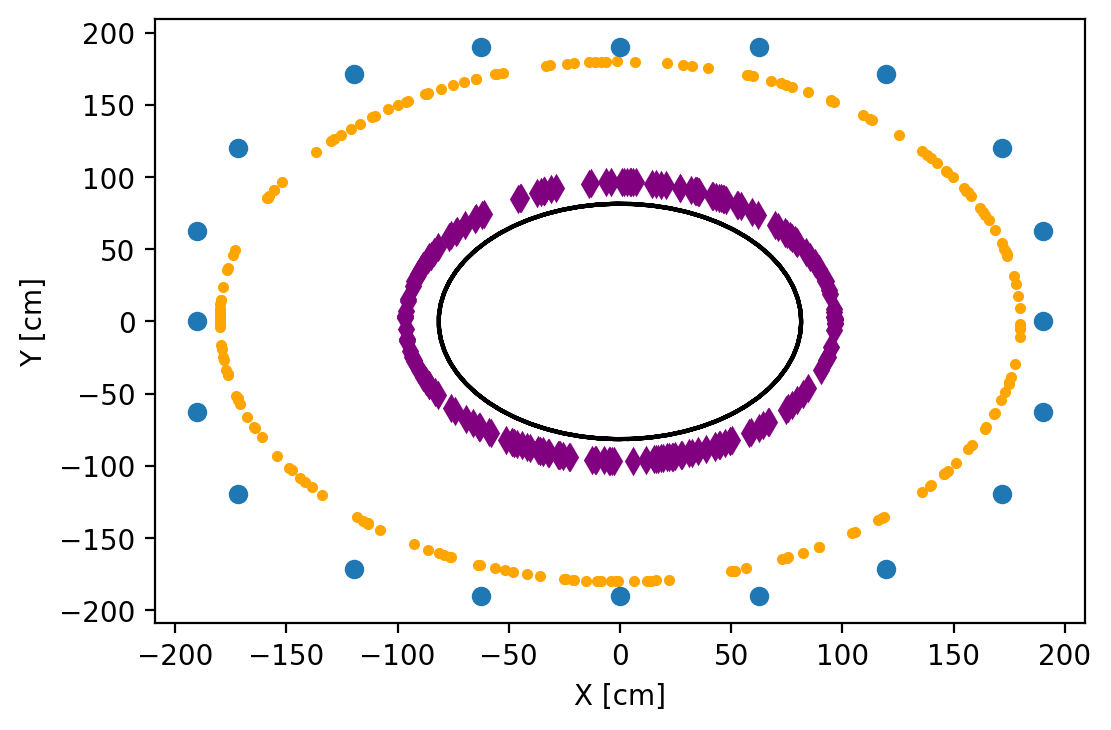

In [82]:
fig, axis = plt.subplots(dpi=200)
plt_tpc_circle()
plt.plot(neutron_x, neutron_y, marker='d', color='purple', ls='')
plt.plot(gamma_x, gamma_y, marker='.', color='orange', ls='')
plt.plot(pmts_in_z_slice[:, 0], pmts_in_z_slice[:, 1], marker='o', ls='')
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')

In [83]:
emission_point_n = np.zeros((n_source_points, 3))
emission_point_n[:, 0] = neutron_x
emission_point_n[:, 1] = gamma_y
neutron_model = NeutronVetoToyLightPropagator(
    81.5, 
    pmts_in_z_slice,
    emission_point_n,
)

emission_point_bkg = np.zeros((n_source_points, 3))
emission_point_bkg[:, 0] = gamma_x
emission_point_bkg[:, 1] = neutron_y
bkg_model = NeutronVetoToyLightPropagator(
    81.5, 
    pmts_in_z_slice,
    emission_point_bkg,
)

Lets create 2500 images per source position. This will require about 8 GB of memory. If you have only less memory available you should reduce `n_images_per_source`  to maybe 1000.

In [84]:
photon_charge_resolution = 0.3
photon_charge_threshold = 0.15  # Does not cut events only clips their charge
time_binning = np.arange(0, 32.1, 2)

n_images_per_source = 2500
n_ph = 25

offsets, times, channel, charge = neutron_model.generate_events(n_images_per_source, 
                                                                n_ph,
                                                                photon_charge_resolution,
                                                                photon_charge_threshold,
                                                               )
images_n = neutron_model.make_sample(offsets, 
                                     times, 
                                     channel, 
                                     charge, time_bins=time_binning
                                    )

offsets, times, channel, charge = bkg_model.generate_events(n_images_per_source, 
                                                            n_ph,
                                                            photon_charge_resolution,
                                                            photon_charge_threshold,
                                                           )
images_bkg = bkg_model.make_sample(offsets, 
                                   times, 
                                   channel, 
                                   charge, time_bins=time_binning
                                  )

# Normalizing images:
max_charge_n = np.max(images_n)
images_n /= max_charge_n

max_charge_bkg = np.max(images_bkg)
images_bkg /= max_charge_bkg

assert len(images_n) == len(images_bkg)
n_events = len(images_n)

# Make common image buffer:
images = np.concatenate([images_n, images_bkg])

# Create labels for images:
image_labels = np.zeros((2*n_events, 2), dtype=np.int8)
image_labels[:n_events, 0] = 1
image_labels[n_events:, 1] = 1

# Shuffle data and create training and validation set:
inds = np.arange(0, 2*n_events, 1)
np.random.shuffle(inds)
images = images[inds]
image_labels = image_labels[inds]

n_events = len(images)
n_training = int(n_events*0.8)

images_training = images[:n_training]
labels_training = image_labels[:n_training]

n_valid = n_events - n_training
images_validation = images[-n_valid:]
labels_validation = image_labels[-n_valid:]

In [85]:
batch_size = 512
epochs = 10

Let us started with the model without the circular padding to see its impact:

In [ ]:
my_timer_callback = TimerCallback()
checkpoint_names = './data/checkpoints/my_cnn_model_best_check_point.ckpt'

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_names, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True,
)


model = my_sequential_model()
cnn_statistics = model.fit(images_training, 
                           labels_training, 
                           batch_size=batch_size, 
                           epochs=epochs,  
                           validation_data=(images_validation, labels_validation),
                           callbacks=[cp_callback, my_timer_callback]
                          )

Epoch 1/10
 458/1563 [=======>......................] - ETA: 46s - loss: 0.5348 - accuracy: 0.7169

In [ ]:
my_timer_callback = TimerCallback()
checkpoint_names = './data/checkpoints/my_cnn_model_circ_padding_best_check_point.ckpt'

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_names, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True,
)


model_circ_padding = my_sequential_model_circ_padding()
cnn_statistics_circ_padding = model_circ_padding.fit(
    images_training, 
    labels_training, 
    batch_size=batch_size, 
    epochs=epochs,  
    validation_data=(images_validation, labels_validation),
    callbacks=[cp_callback, my_timer_callback]
)

In [ ]:
fig, axis = plt.subplots(dpi=300)
axis.plot(cnn_statistics.history['accuracy'], ls='-.', marker='.', 
          label='Training (regular padding)', color='purple')
axis.plot(cnn_statistics.history['val_accuracy'], ls='-.', marker='.', 
          label='Validation (regular padding)', color='orange')
axis.plot(cnn_statistics_circ_padding.history['accuracy'], ls='-', marker='.', 
          label='Training (circular padding)', color='purple')
axis.plot(cnn_statistics_circ_padding.history['val_accuracy'], ls='-', marker='.', 
          label='Validation (circular padding)', color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()


fig, axis = plt.subplots(dpi=300)
axis.plot(cnn_statistics.history['loss'], marker='.', ls='-.', 
          label='Training loss (regular padding)', color='purple')
axis.plot(cnn_statistics.history['val_loss'], marker='.', ls='-.', 
          label='Validation loss (regular padding)', color='orange')
axis.plot(cnn_statistics_circ_padding.history['loss'], marker='.', 
          label='Training loss (circular padding)', color='purple')
axis.plot(cnn_statistics_circ_padding.history['val_loss'], marker='.', 
          label='Validation loss (circular padding)', color='orange')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

It looks like both models show roughly the same performs.

# Conclusion:

In this notebook we have seen how to create simple CNNs using tensorflow. We learned a bit about the different structures involved like. Convolution, Max Pooling and dense layers. In addition we have seen how we can customize or models using Callback functions and how we can define our own layers e.g. to apply a circular padding for circular problems. 

I hope you learned something and enjoyed the notebook. All the best for your own application!